# Clustering stocks by price and volume movements

Associative movements in stock prices are referred to as **sympathy plays**, which typically occur when a company’s stock is indirectly affected by another company’s stock or news. Sympathy plays may drive another stock, a group of stocks, or possibly an entire sector in a particular direction as their trades gain momentum. 

This research will explore **unsupervised clustering methods to group stocks in the medical specialties and pharmaceutical industries listed on NASDAQ that exhibit similar patterns in hourly price movement as an empirical measure**. The clusters may help day traders to narrow down stocks in a watchlist for a sympathy play strategy, or provide indication of similar stocks to avoid in a diversification strategy.

**Related works**

The application of clustering methods on stocks and mutual funds has been explored in various studies spanning across different markets, equities and financial metrices.

Nanda et al. explored KMeans, Self-Organizing Maps and Fuzzy C-means methods to categorize stocks in the Bombay Stock Exchange based on stock returns and their valuation ratios, and found the KMeans method to be the most successful [1]. In further literature, KMeans clustering was also commonly used among researchers studying different markets [2, 3, 4].

Research by Tekin & Gümüş also explored hierarchical clustering of stocks in the Borsa Istanbul (BIST 100) index using 10 financial indicators: price / earnings ratio, market value / book value ratio, dividend yield, return on assets, return on equity, change in sales and equity, return on average, return and risk [5]. These indicators are usually considered in fundamental analysis of companies.

While fundamental financial indicators were commonly used in cluster analysis of stocks, fewer publications looked at technical indicators such as stock price movement and volume. Bai and Dang’s exploratory study used a Gaussian Mixture Model method to examine price-volume clusters of a particular stock [6]. Further research by Rukmi et al. used technical information on stock prices, transaction date/time, volume, buyer and seller to identify transactional outliers which could be indicative of stock price manipulation [7].

As an extension of research in this field, this study will attempt to cluster stocks in the medical specialties and pharmaceutical industries listed on NASDAQ based on similarities in hourly price movements. Various clustering methods will be evaluated to determine the most optimal method and number of clusters for this use case.


# 0 Import libraries

In [ ]:
# Install yahoo finance
!pip install yfinance

     |████████████████████████████████| 6.4 MB 38.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# Import relevant libraries

import numpy as np
import pandas as pd
pd.options.display.max_columns = None

import datetime

import yfinance as yf

from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn import metrics, preprocessing, feature_selection, linear_model, model_selection
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, AffinityPropagation
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator
plt.style.use('default')
%matplotlib inline


import seaborn as sns
sns.set_style("ticks")
from IPython.display import display


import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
pio.templates.default = "plotly_white"

# 1 Load data

## 1.1 Shortlisting stocks for analysis

The stocks were filtered down to the research’s area of interest
1. Medical specialties industry
2. Pharmaceutical industries

Stock movements in the abovementioned industries are sensitive to news on clinical trials and patents, and such reports occurring on an almost daily basis make these industries good candidates for monitoring. 

We use Tradingview's stock screener to filter down to
1. Exchange: NASDAQ
2. Symbol type: Common Stock
3. Industry: Medical Specialties, Pharmaceuticals: Generic, Major, Other

As this is a paid service, we export the filtered results into an .xlsx file.

In [ ]:
# Import pharma stocks data from Excel
df_pharma = pd.read_excel('/content/drive/MyDrive/Specialist Diploma in Data Science (AI)/IT8302 Applied Machine Learning/Assignment/CA2/Stocks/pharma_stocks.xlsx', sheet_name='Tickers')

df_pharma.describe()

Market Capitalization  Shares Float  Relative Volume
count           4.480000e+02  4.450000e+02       448.000000
mean            1.540485e+09  4.699819e+07         0.469381
std             6.720056e+09  8.180833e+07         2.165901
min             9.184645e+06  0.000000e+00         0.005754
25%             6.441137e+07  1.309293e+07         0.171367
50%             1.975072e+08  2.637747e+07         0.270251
75%             7.030511e+08  5.125242e+07         0.430789
max             1.089211e+11  1.206546e+09        45.401751

##1.2 Import stock data from Yahoo Finance

Considering the volatility in intraday trading, stock movements were calculated at **hourly intervals**. The hourly level of granularity would sufficiently reduce noise at minute- or second-level intervals, yet preserving the ability to map out stock patterns throughout a day. A total of 447 stocks and 887 trading hours’ worth of data was collected at this stage.


**Feature engineering**

Stock `movement` was used as the metric for this analysis, calculated as below:

```
movement = Close – Open
```
Where **`Close` is the closing price** and **`Open` is the opening price**.

This difference contains information on the (i) direction (a positive difference indicates that the stock price went up and vice versa) and (ii) magnitude of the movement. The difference between opening and closing prices are generally preferred over the difference in high and low prices since opening and closing prices are common reference points in the trading domain.

In [ ]:
# Import stock data from yahoo finance, using 1h intervals

ticker_list = df_pharma['Ticker']

df = []

# Loop through the ticker_list and create a long dataframe with volume, movement and ticker columns
for ticker in ticker_list:
  data = yf.download(tickers = ticker,
                     start="2021-07-01",
                     end="2021-12-31",
                     #period = '6mo',
                    interval = '60m',
                    auto_adjust = True)
  data2 = pd.DataFrame(data['Volume'])
  data2['Movement']= data['Open'] - data['Close']
  data2 ['Ticker'] = ticker
  df.append(data2)

# Combine the appended lists into a dataframe
df = pd.concat(df)

# Extract movement values to make df_movement
df_movement = pd.DataFrame(df[['Movement','Ticker']])

# Pivot long to wide then transpose so that each row is a ticker and each column is a time
df_movement = df_movement.pivot(columns = 'Ticker', values = 'Movement')
df_movement = df_movement.T




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# 2 Exploratory Data Analysis
We notice
1. There are many missing values - in particular, there is 1 hour with 398 blanks.
2. The scales are different for differnt tickers, hence, some **normalisation** must be done.

In [ ]:
# Show info on df_movement
print("Shape: ",df_movement.shape)

df_movement.info()


Shape:  (447, 891)
<class 'pandas.core.frame.DataFrame'>
Index: 447 entries, ABEO to ZYXI
Columns: 891 entries, 2021-07-01 09:30:00-04:00 to 2022-02-23 16:00:00-05:00
dtypes: float64(891)
memory usage: 3.1+ MB


In [ ]:
df_movement.describe()

2021-07-01 09:30:00-04:00  2021-07-01 10:30:00-04:00  \
count                 402.000000                 395.000000   
mean                   -0.175166                   0.186472   
std                     1.107349                   0.669413   
min                    -7.650024                  -3.269999   
25%                    -0.197500                   0.000000   
50%                     0.000000                   0.050000   
75%                     0.060000                   0.207500   
max                    12.279999                   6.240005   

       2021-07-01 11:30:00-04:00  2021-07-01 12:30:00-04:00  \
count                 395.000000                 397.000000   
mean                   -0.075841                  -0.019220   
std                     0.407410                   0.345322   
min                    -2.649994                  -2.989998   
25%                    -0.120000                  -0.048500   
50%                    -0.015100                   0.000900   
75%                     0.011050                   0.050500   
max                     2.764999                   2.505524   

       2021-07-01 13:30:00-04:00  2021-07-01 14:30:00-04:00  \
count                 392.000000                 395.000000   
mean                   -0.040038                  -0.004927   
std                     0.339068                   0.302678   
min                    -3.219971                  -2.925003   
25%                    -0.055000                  -0.040000   
50%                    -0.001500                   0.000000   
75%                     0.030000                   0.049999   
max                     1.095001                   1.689896   

       2021-07-01 15:30:00-04:00  2021-07-02 09:30:00-04:00  \
count                 399.000000                 399.000000   
mean                   -0.043507                   0.318178   
std                     0.317585                   0.712472   
min                    -2.989990                  -1.669998   
25%                    -0.070000                   0.030000   
50%                    -0.005000                   0.130001   
75%                     0.030000                   0.382200   
max                     0.849998                   7.025574   

       2021-07-02 10:30:00-04:00  2021-07-02 11:30:00-04:00  \
count                 398.000000                 395.000000   
mean                    0.044282                  -0.024474   
std                     0.412677                   0.340999   
min                    -2.439995                  -3.085022   
25%                    -0.030000                  -0.069996   
50%                     0.015000                  -0.005000   
75%                     0.115000                   0.030100   
max                     4.214996                   2.741600   

       2021-07-02 12:30:00-04:00  2021-07-02 13:30:00-04:00  \
count                 399.000000                 391.000000   
mean                   -0.078709                  -0.015727   
std                     0.341501                   0.208711   
min                    -4.330017                  -1.710022   
25%                    -0.109998                  -0.065000   
50%                    -0.015000                  -0.003900   
75%                     0.010000                   0.024947   
max                     1.400002                   1.599991   

       2021-07-02 14:30:00-04:00  2021-07-02 15:30:00-04:00  \
count                 397.000000                 398.000000   
mean                   -0.020163                   0.049986   
std                     0.279771                   0.237412   
min                    -2.279999                  -1.539993   
25%                    -0.055000                  -0.010000   
50%                    -0.000100                   0.018800   
75%                     0.044998                   0.088749   
max                     0.894999                   1.699997   

       2021-07-06 09:30:00-04:0

# 3 Data Preperation

## 3.1 Drop missing values
We want to preserve as much historical info on each ticker as possible, to find similar patterns with other tickers. We drop all missing values with the aim of keeping as many columns as possible (i.e. it is ok to sacrifice some tickers to preserve as many columns as possible).

In [ ]:
# Preparing the data

# We will keep columns with at least 402 values (i.e. max 10 % missing values)
df_movement_clean = df_movement.dropna(axis='columns', thresh = 402)

# Next, we drop the rows with nulls
df_movement_clean = df_movement_clean.dropna(axis = 0)

# Check the shape of the dataframe
print("Shape: ",df_movement_clean.shape)

Shape:  (279, 758)


## 3.2 Normalise the data
Since each ticker has a different scale, we use **Normalizer** to normalise data for each ticker (i.e. across rows).

In [ ]:
# Normalise the data
df_movement_normalized = preprocessing.Normalizer().fit_transform(df_movement_clean)

# Format it as a pandas Dataframe
df_movement_normalized = pd.DataFrame(df_movement_normalized, index=df_movement_clean.index)

# Export to csv
df_movement_normalized.to_csv('/content/drive/MyDrive/Specialist Diploma in Data Science (AI)/IT8302 Applied Machine Learning/Assignment/CA2/Stocks/normalised.csv')

#Preview dataframe
df_movement_normalized.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,


0         1         2         3         4         5         6    \
Ticker                                                                         
YMAB   -0.010200  0.062903  0.030176 -0.075653 -0.034851 -0.020401  0.059077   
ZGNX   -0.128671  0.008436 -0.026363  0.007382  0.018981  0.120214  0.016872   
ZSAN    0.024445  0.030374  0.089028  0.052539  0.001459  0.031016  0.029553   
ZYNE    0.011075  0.102833  0.039551  0.055372 -0.033776  0.071192  0.027686   
ZYXI   -0.197749  0.050000 -0.004545 -0.030682 -0.010227 -0.102272 -0.031682   

             7         8         9         10        11        12        13   \
Ticker                                                                         
YMAB    0.003400 -0.001275 -0.034001  0.030176 -0.007650 -0.140255  0.006375   
ZGNX    0.004218  0.187703 -0.031614  0.002109 -0.006327 -0.050616 -0.081197   
ZSAN   -0.003648  0.028459 -0.014594  0.008756 -0.012770 -0.003773  0.035026   
ZYNE   -0.015820 -0.087645  0.007910  0.027686 -0.007910  0.039551 -0.059327   
ZYXI   -0.063636 -0.031818 -0.065908  0.170453 -0.045454 -0.052272 -0.077272   

             14        15        16        17        18        19        20   \
Ticker                                                                         
YMAB   -0.008075  0.000850 -0.036551  0.038252 -0.017001 -0.059927 -0.057377   
ZGNX   -0.020036  0.025308 -0.076980  0.016872  0.014763  0.000000 -0.044290   
ZSAN    0.006202  0.008392 -0.012770 -0.041958 -0.007297 -0.049620 -0.008757   
ZYNE    0.023731  0.019776 -0.079102 -0.037573  0.023730 -0.047461 -0.059327   
ZYXI    0.036363 -0.045454  0.036363  0.013636  0.043182 -0.013637 -0.006818   

             21        22        23        24        25        26        27   \
Ticker                                                                         
YMAB   -0.002550 -0.051002  0.051852  0.007225  0.044202  0.067577 -0.027626   
ZGNX    0.071707 -0.037962 -0.018981  0.054835  0.037962 -0.016872  0.042181   
ZSAN    0.065309  0.047738 -0.014594  0.001824  0.051809  0.006932  0.052721   
ZYNE    0.102833  0.015820  0.024996  0.023731 -0.142384  0.015820 -0.003955   
ZYXI   -0.026136  0.001136 -0.006818  0.006818 -0.098454  0.031818 -0.047727   

             28        29        30        31        32        33        34   \
Ticker                                                                         
YMAB    0.055252 -0.008075  0.026351 -0.051002  0.004675 -0.062903  0.047636   
ZGNX    0.040198 -0.044289 -0.042181 -0.013709  0.016872  0.078034 -0.012443   
ZSAN    0.098875  0.000730 -0.039284 -0.006567  0.011858  0.010946  0.014229   
ZYNE    0.094923 -0.015820 -0.047461 -0.019775  0.043506  0.087012 -0.039551   
ZYXI    0.068181  0.025000  0.003136 -0.013637  0.015909  0.034091  0.027250   

             35        36        37        38        39        40        41   \
Ticker                                                                         
YMAB    0.018276  0.026351 -0.010201  0.005950  0.028901 -0.017851 -0.006800   
ZGNX   -0.014763  0.050616  0.001054  0.002109  0.014763 -0.008436 -0.010545   
ZSAN    0.010577  0.007479 -0.022982  0.023165  0.051080 -0.004013  0.000000   
ZYNE   -0.039551  0.023730  0.031641  0.015820 -0.055371 -0.011865  0.007910   
ZYXI   -0.004545 -0.020454  0.018182  0.040909  0.074999 -0.009409  0.015909   

             42        43        44        45        46        47        48   \
Ticker                                                                         
YMAB   -0.005100 -0.005950  0.042502  0.028901 -0.028901 -0.065453 -0.003825   
ZGNX   -0.092797  0.026363  0.066434  0.033744 -0.021090 -0.063270 -0.002109   
ZSAN    0.022256  0.007662  0.043417  0.008027 -0.008027 -0.092669  0.058741   
ZYNE   -0.007910  0.022544  0.063361  0.047461 -0.011865 -0.039551  0.000000   
ZYXI    0.054545  0.019318  0.102272 -0.018182 -0.027272  0.061363 -0.114499   

             49        50        51        52        53        54        55   \
Ticker

# 4 Modelling

## 4.1 Visualise distributions in a 3D space (using 3 principal components)
First, we try to see if there are any visible clusters.

In [ ]:
# To reduce the number of dimensions, we do PCA with n_components explaining for 90% of the variance
percent_variance = 0.9

pca = PCA(n_components=percent_variance, random_state = 42)
pca_result = pca.fit_transform(df_movement_normalized)

print('shape = ' + str(pca_result.shape))

# Store the number of PCs that account for 90% of the variance
n_components = 177

# Create dataframe for PC
pc_nums = np.arange(n_components)+1
df_pc = pd.DataFrame(pca_result, columns = pc_nums, index = df_movement_normalized.index)
df_pc = df_pc.add_prefix('pc')

varaince_3pca_components = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1] + pca.explained_variance_ratio_[2]
print("The first 3 PCA compoments account for %.3f of the variance." %varaince_3pca_components)
print("There will be some data loss when using the first 2 to 3 PCs, but it is acceptable since here it is only used for visualisation purposes.")


# Concatanate pcs with original (non-standardised) df
df_withpc = pd.concat([df_movement_clean,df_pc],axis = 1)

# Visualise the principal components and clusters in a 3D space
fig = px.scatter_3d(df_pc, x='pc1', y='pc2', z= 'pc3',
                    title = 'PCA Visualisation',
                    hover_data=[df_pc.index],
                    opacity=0.7
              )


fig.show()

shape = (279, 177)
The first 3 PCA compoments account for 0.080 of the variance.
There will be some data loss when using the first 2 to 3 PCs, but it is acceptable since here it is only used for visualisation purposes.


##4.2 Define functions

In [ ]:
# Define function to plot silhouette and scatter plots with centers

def plot_silhouette_scatter_withcenters(X_with_pc, range_n_clusters,scatter_x,scatter_y):
    
    # Silhouette plot

    y_lower = 10 # for adjusting y-axis of the silhouette plot

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color,alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlim([-0.5, 0.5]) # Adjust axis of silhouette plot (silhouette coefficient can range from -1, 1)
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_title("Silhouette plot", fontsize=14)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="k", linestyle="--")
    ax1.text(silhouette_avg+0.01,5,'Average = %.3f' % silhouette_avg, fontsize = 12)

    # =========================
    # Scatterplot

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_with_pc[scatter_x], X_with_pc[scatter_y], marker='.', s=50, alpha=0.7,
                    c=colors)

    # Get cluster centres
    centers = clusterer.cluster_centers_
    centers_pca = PCA(2, random_state = 42).fit_transform(centers)

    # Draw white circles at cluster centers
    ax2.scatter(centers_pca[:, 0], centers_pca[:, 1],
                    marker='o', c="white", alpha=1, s=300, edgecolor='k')

    # Label clusters
    for i, c in enumerate(centers_pca):
        ax2.scatter(c[0], c[1],
                        marker='$%d$' % (i+1), alpha=1,
                        s=100, color='k')

    ax2.set_title("Scatterplot with clusters", fontsize = 14)
    ax2.set_xlabel(scatter_x)
    ax2.set_ylabel(scatter_y)

    #plt.suptitle(("Silhouette analysis for KMeans clustering with n_clusters = %d" % n_clusters),
    #                fontsize=16, fontweight='bold')
    plt.show()     

    
# ==========================================================
# Define function to plot silhouette and scatter plots without centers

def plot_silhouette_scatter_nocenters(X_with_pc, range_n_clusters,scatter_x,scatter_y):
    
    # Silhouette plot

    y_lower = 10 # for adjusting y-axis of the silhouette plot

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color,alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlim([-0.5, 0.5]) # Adjust axis of silhouette plot (silhouette coefficient can range from -1, 1)
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_title("Silhouette plot", fontsize=14)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="k", linestyle="--")
    ax1.text(silhouette_avg+0.01,5,'Average = %.3f' % silhouette_avg, fontsize = 12)

    # =========================
    # Scatterplot

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_with_pc[scatter_x], X_with_pc[scatter_y], marker='.', s=50, alpha=0.7,
                    c=colors)


    ax2.set_title("Scatterplot with clusters", fontsize = 14)
    ax2.set_xlabel(scatter_x)
    ax2.set_ylabel(scatter_y)

    #plt.suptitle(("Silhouette analysis for n_clusters = %d" % n_clusters),
    #                 fontsize=16, fontweight='bold')
    plt.show()
    
     
    
# ==========================================================
# Define function for elbow plot
def plot_elbow(range_n_clusters, silhouette_avg_n_clusters):
    fig, ax = plt.subplots()
    ax.plot(range_n_clusters, silhouette_avg_n_clusters, color = 'grey', marker = 'o')
    ax.set_xlabel("Number of clusters (k)")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel("Silhouette score")
    ax.set_title("Silhouette scores by clusters")
    plt.show()

## 4.2 K Means clustering
We first explore KMeans clustering, since it is a popular general purpose unsupervised learning method. Kmeans assigns clusters based on the distances between points.

Several models were fitted while varying the number of clusters. While the Kmeans model with two clusters yielded the highest silhouette coefficients, splitting 279 stocks into two clusters may not be meaningful in practice.

Based on the silhouette scores, **four or six clusters were the next most optimal, however, further analysis of the silhouette scores suggested that the clusters were not clearly defined**.

Silhouette scores nearing zero suggested that clusters may be overlapping, while negative values indicated wrong assignment of points to clusters. 

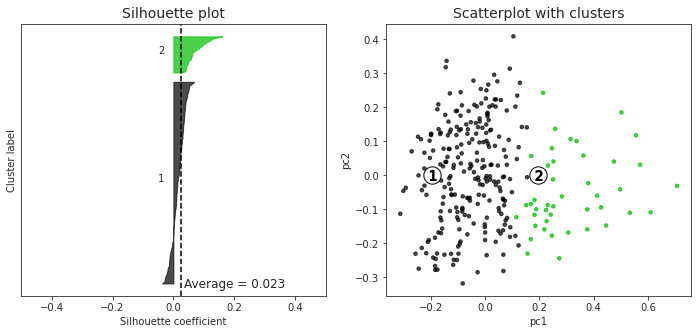

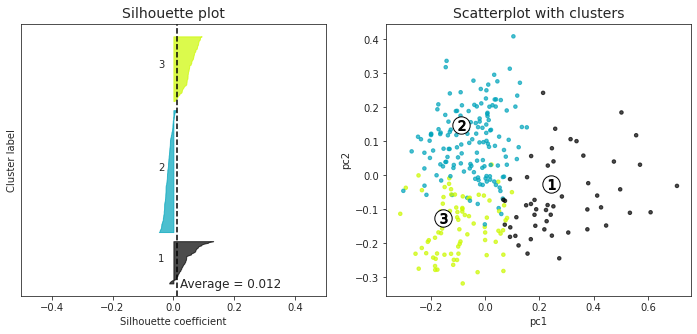

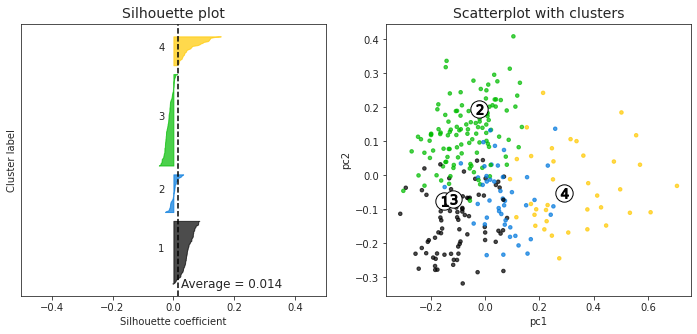

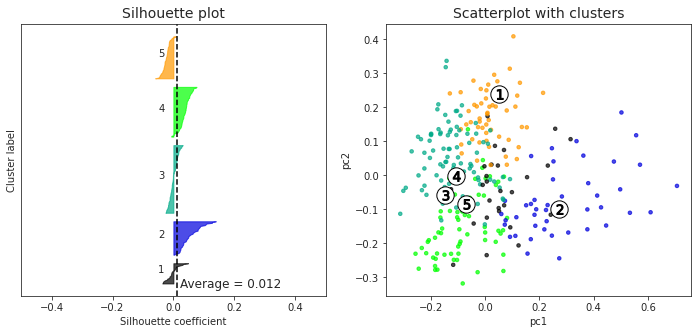

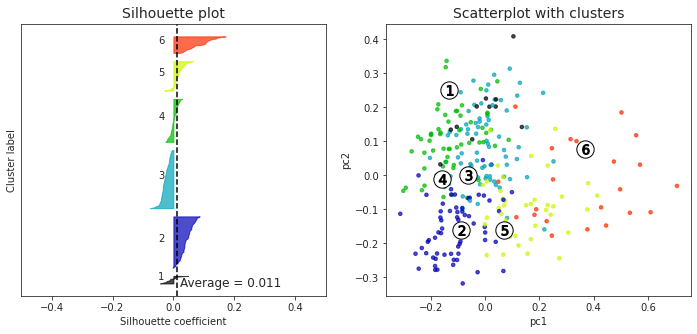

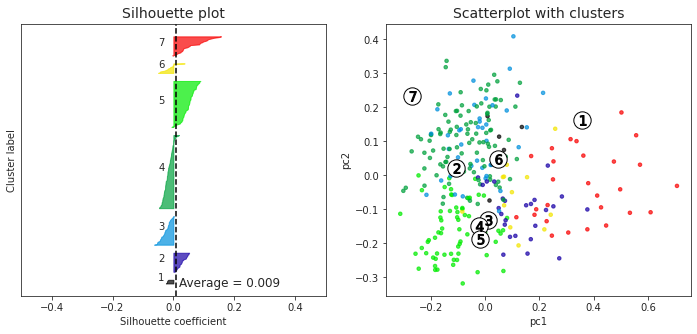

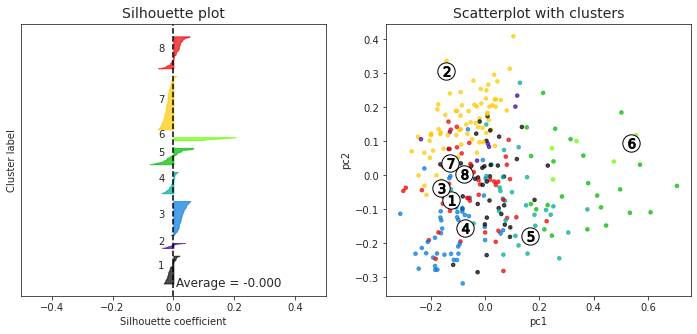

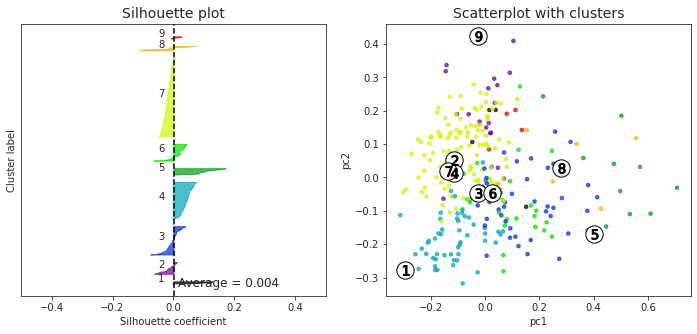

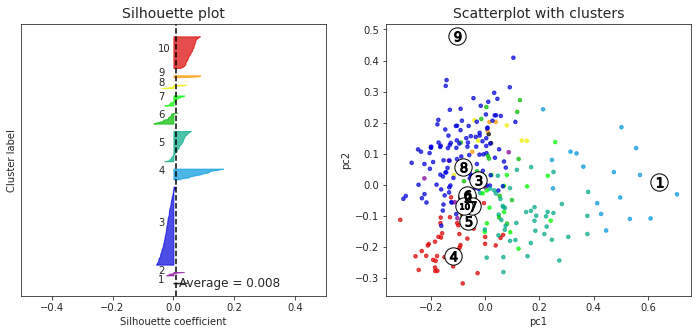

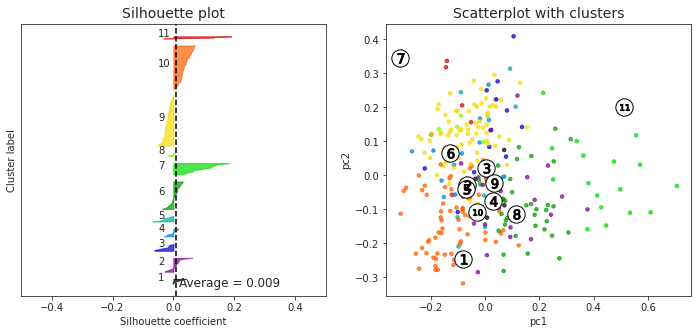

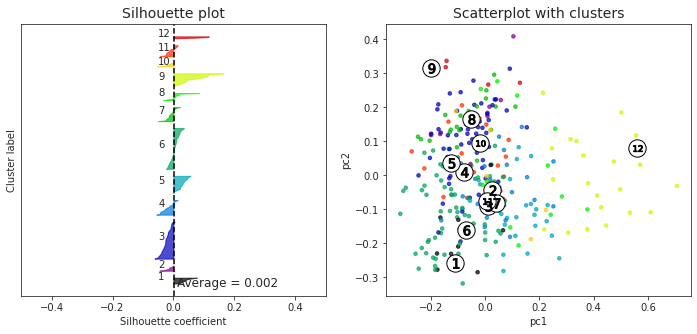

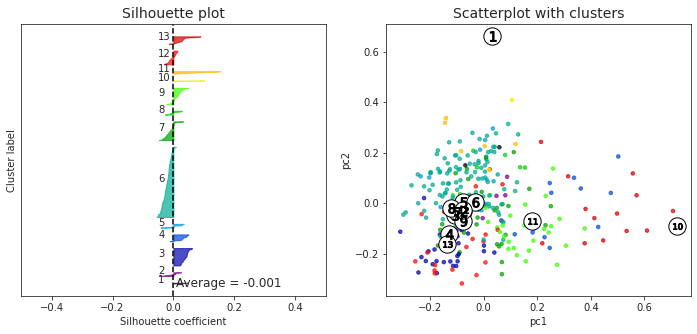

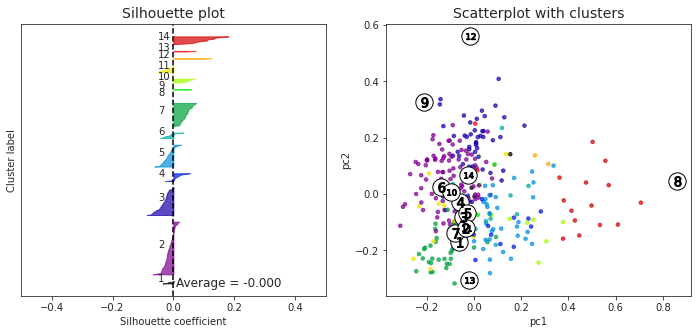

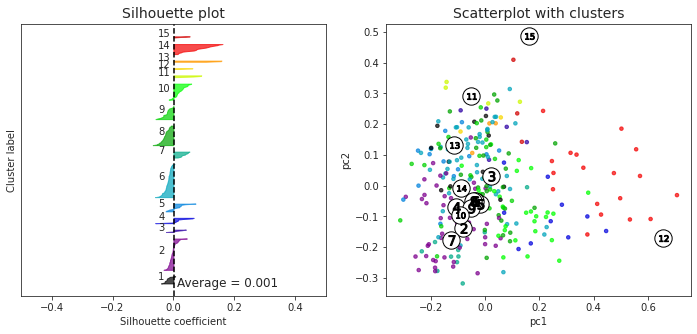

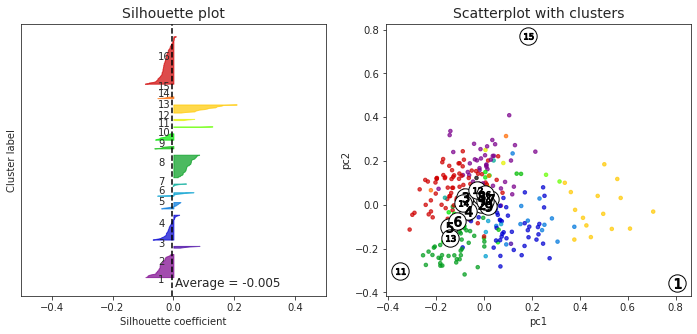

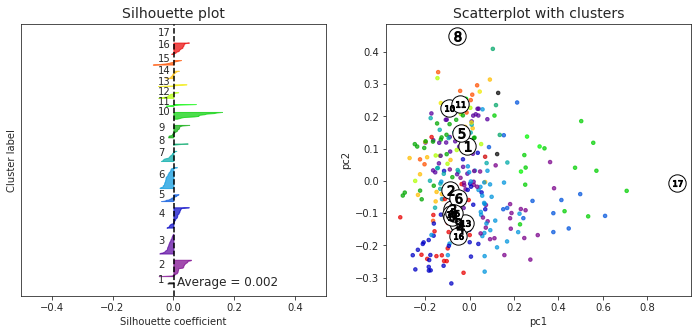

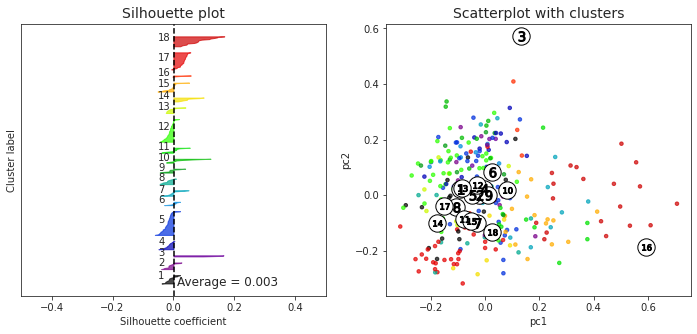

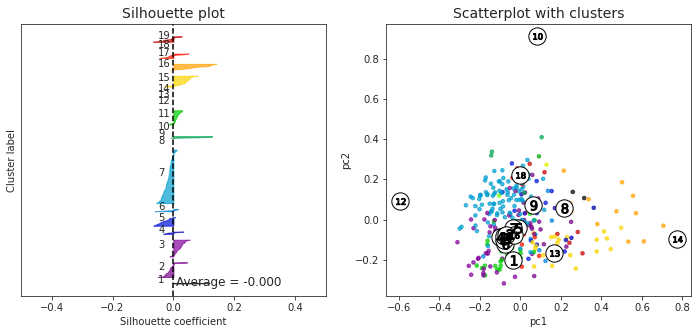

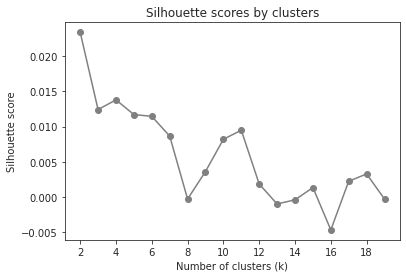

In [ ]:
# Visualising the results of Kmeans clustering

# Specify parameters
X = df_pc
X_with_pc = df_withpc
range_n_clusters = range(2,20)

# Specify the x and y variables to plot
scatter_x = 'pc1'
scatter_y = 'pc2'

# Create list to append avg silhouette scores
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
       
    # Instantiate the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

    # Compute average silhouette_score and append to silhouette_avg_n_clusters list
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_avg_n_clusters.append(silhouette_avg)
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    
    # Plot silhouette and scatter plot
    plot_silhouette_scatter_withcenters(X_with_pc, range_n_clusters,scatter_x,scatter_y)
    
# Plot elbow plot
plot_elbow(range_n_clusters, silhouette_avg_n_clusters)

# 4.3 Agglomerative Clustering
To explore the presence of hierarchical clusters, agglomerative clustering was used as a bottom-up approach. Each stock was paired with another based on similarly to form a cluster, and clusters were paired recursively based on similarity. Ward linkage was used to minimize the variance within each cluster. 

**While the resultant dendrogram suggested a possibility of splitting the data into five clusters, silhouette analysis showed poor separation of the five clusters**.


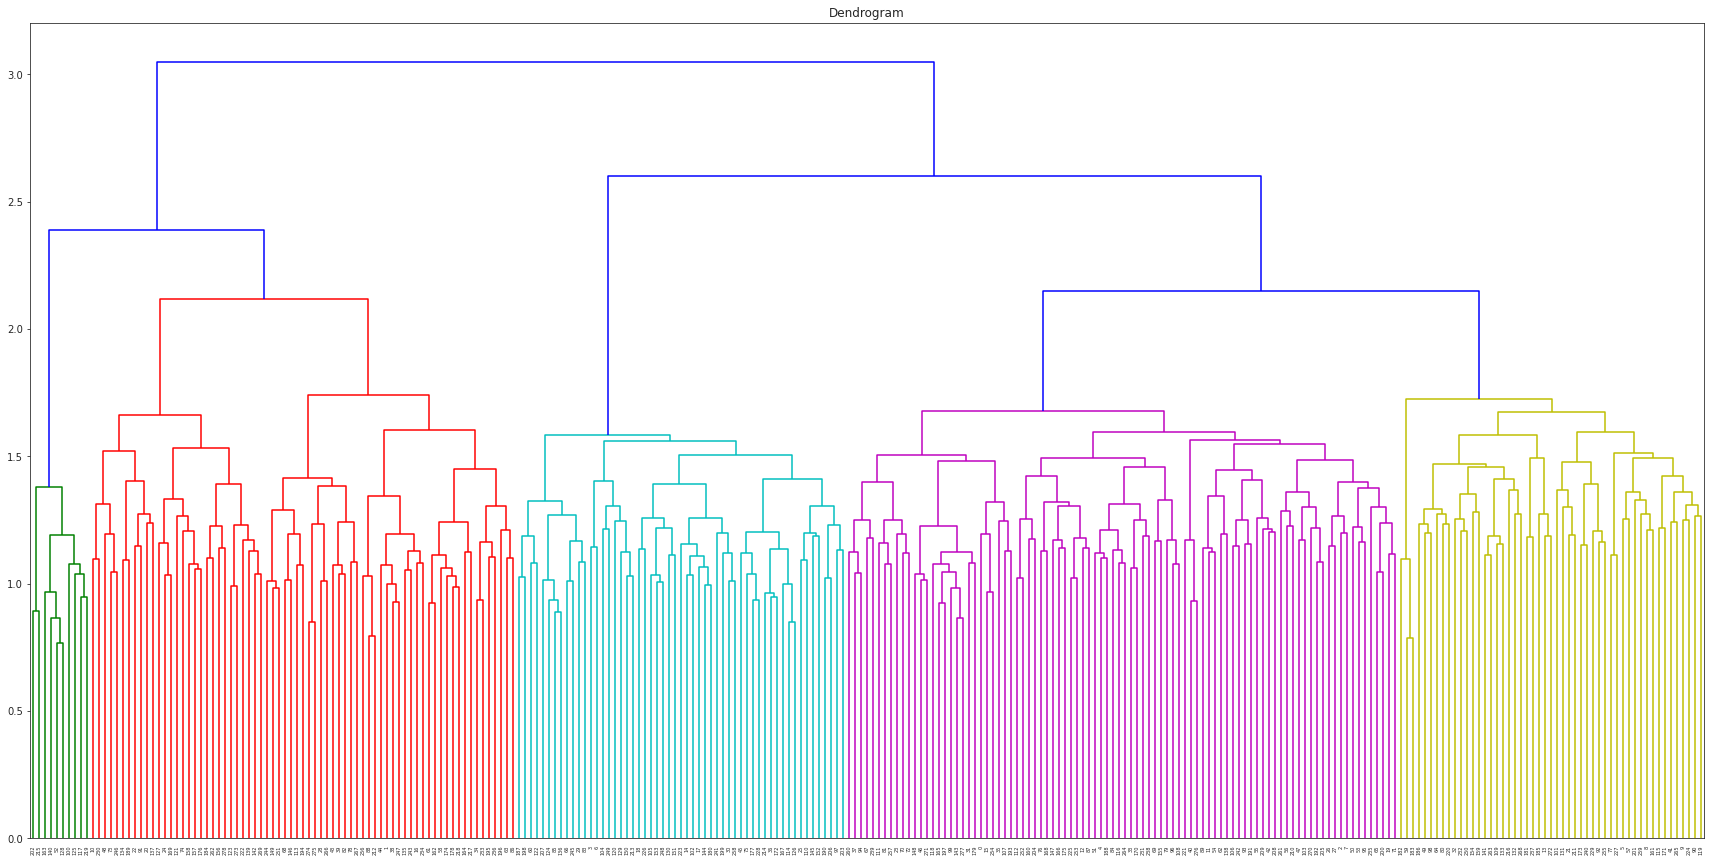

In [ ]:
# Create hierachical clusters
linked = linkage(df_pc,'ward')

# Plot dendrogram
plt.figure(figsize=(30,15))
dendrogram(linked)
plt.title("Dendrogram")
plt.show()

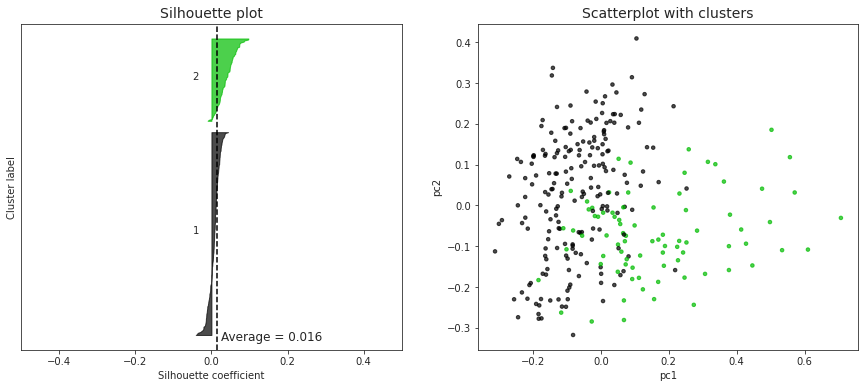

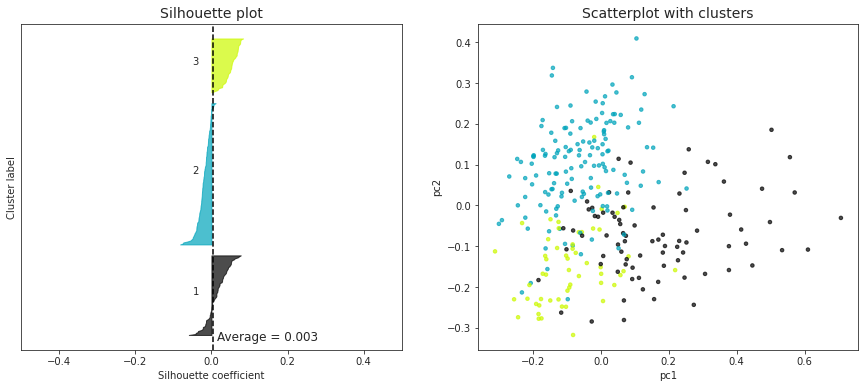

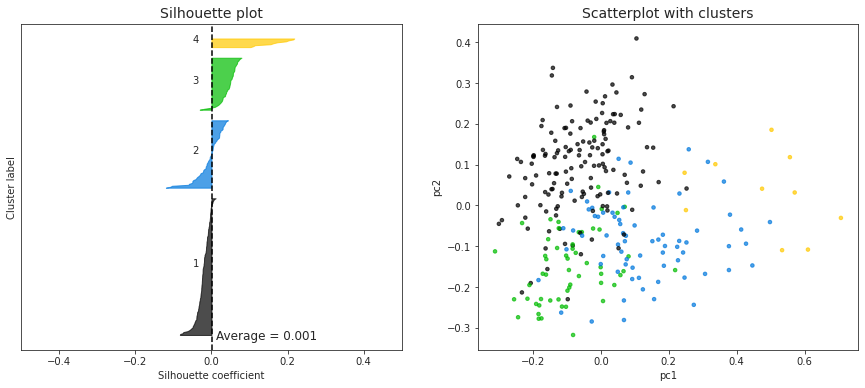

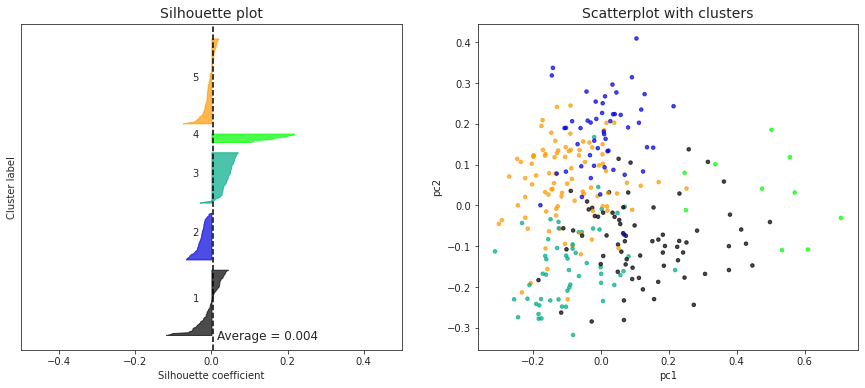

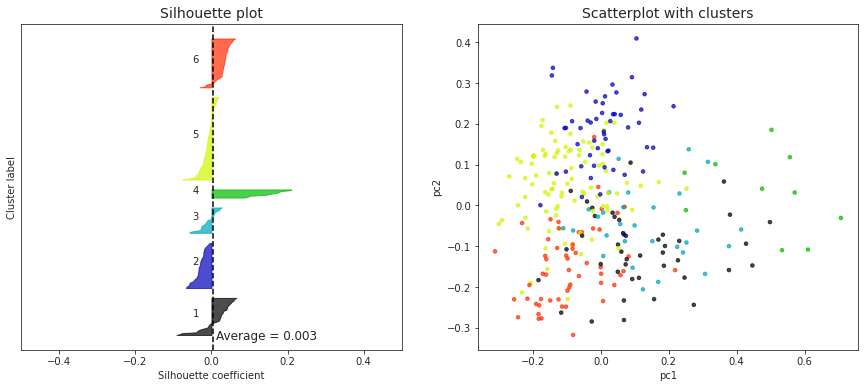

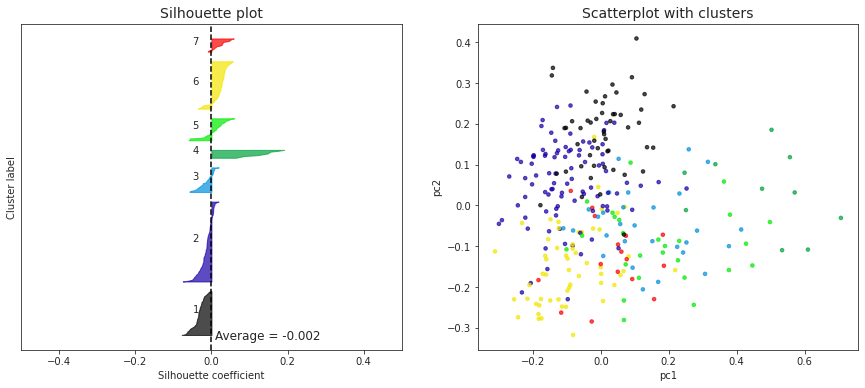

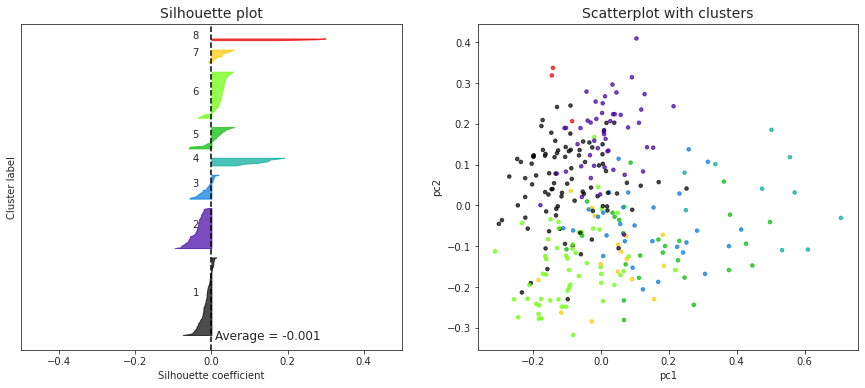

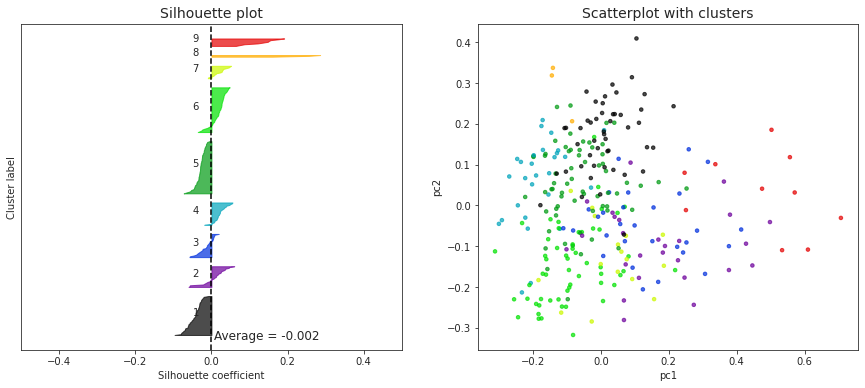

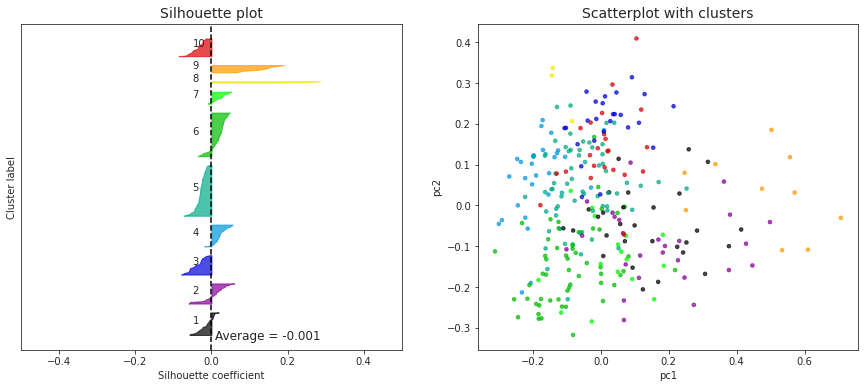

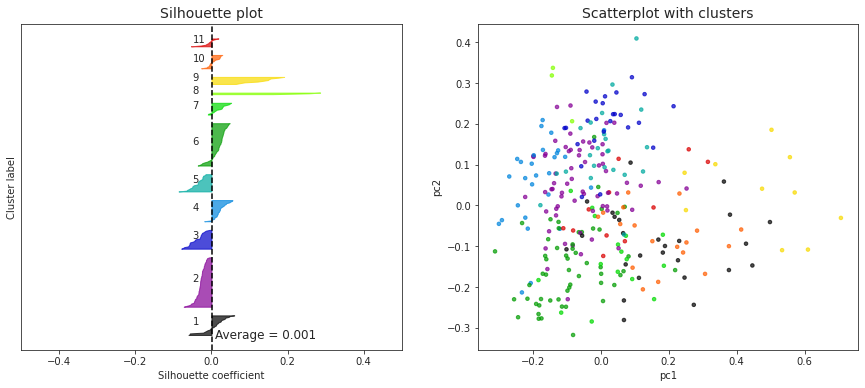

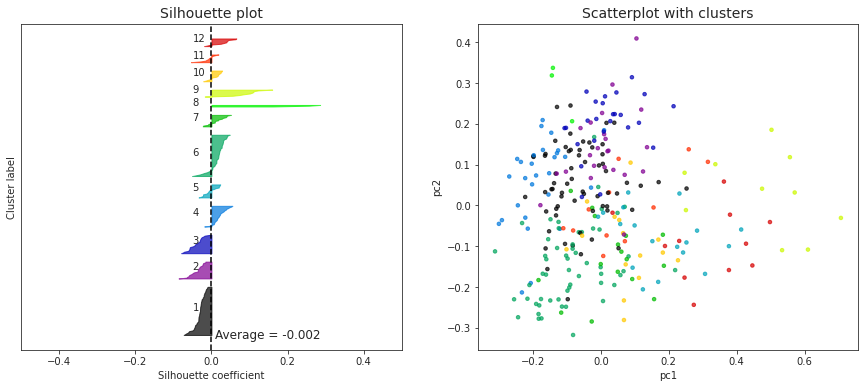

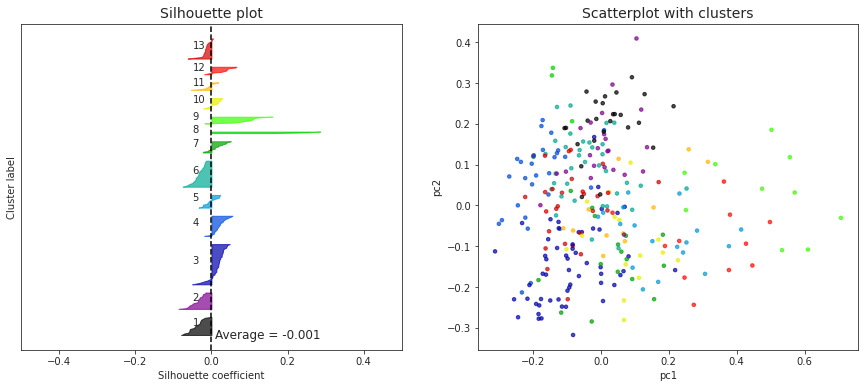

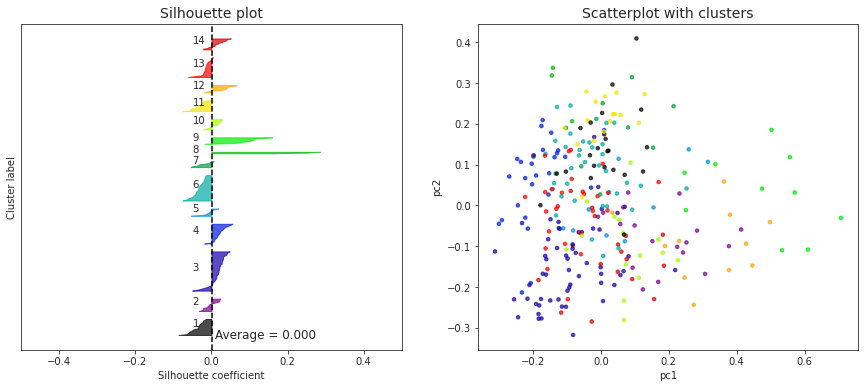

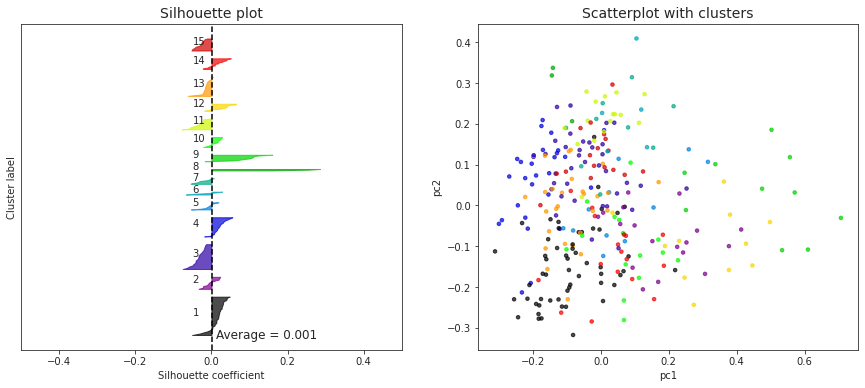

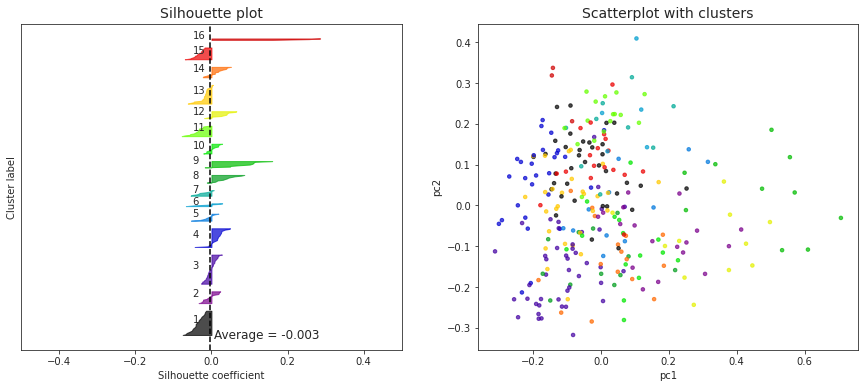

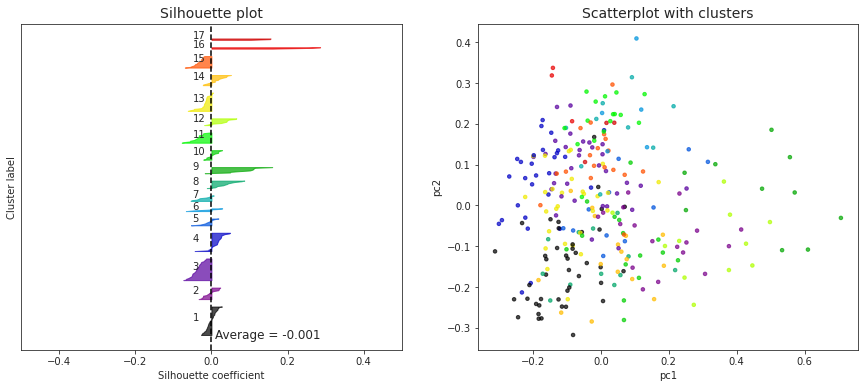

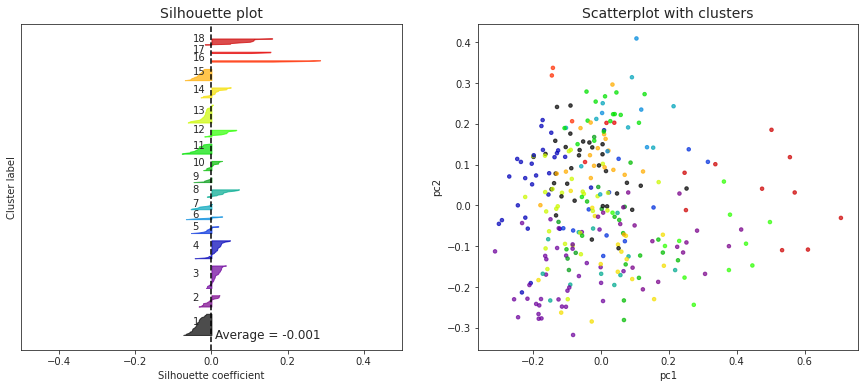

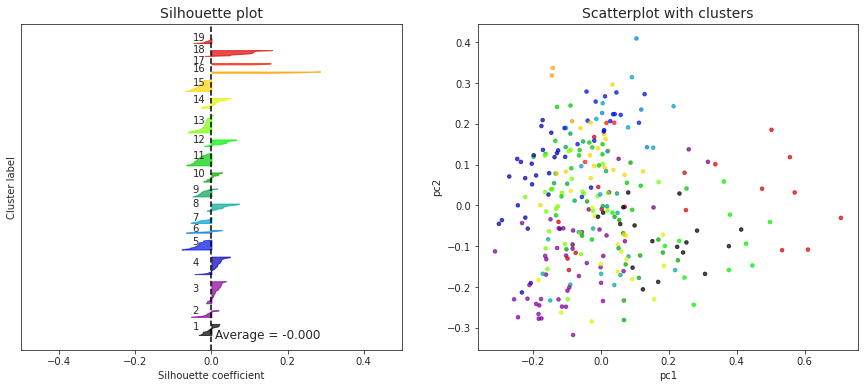

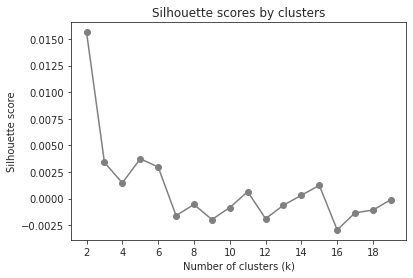

In [ ]:
# Visualising the results of hierachical clustering

# Specify parameters
X = df_pc
X_with_pc = df_withpc
range_n_clusters = range(2,20)

# Specify the x and y variables to plot
scatter_x = 'pc1'
scatter_y = 'pc2'

# Create list to append avg silhouette scores
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
       
    # Instantiate the clusterer with n_clusters value and a random generator
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    cluster_labels = clusterer.fit_predict(X)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

    # Compute average silhouette_score and append to silhouette_avg_n_clusters list
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_avg_n_clusters.append(silhouette_avg)
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 6)
    
    # Plot silhouette and scatter plot
    plot_silhouette_scatter_nocenters(X_with_pc, range_n_clusters,scatter_x,scatter_y)
    
# Plot elbow plot
plot_elbow(range_n_clusters, silhouette_avg_n_clusters)

## 4.4 Spectral Clustering
Spectral clustering first reduces dimensionality based on the spectrum of the data’s similarity matrix, then performing clustering. The method is commonly applied to graph data, but can also be used to cluster non-graph data. 

Considering its flexibility, spectral clustering was used to explore if more well-defined clusters could be identified; however, **low silhouette scores similarly suggested the presence of overlapping clusters**.




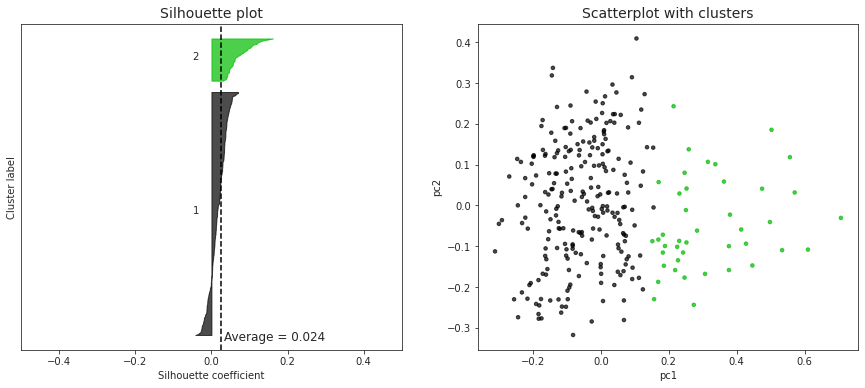

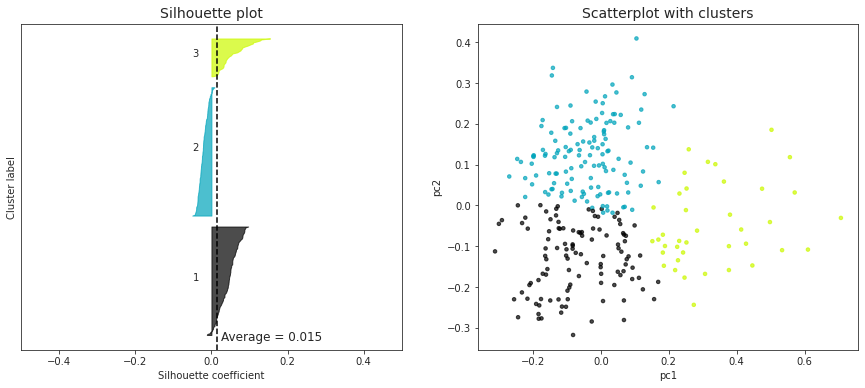

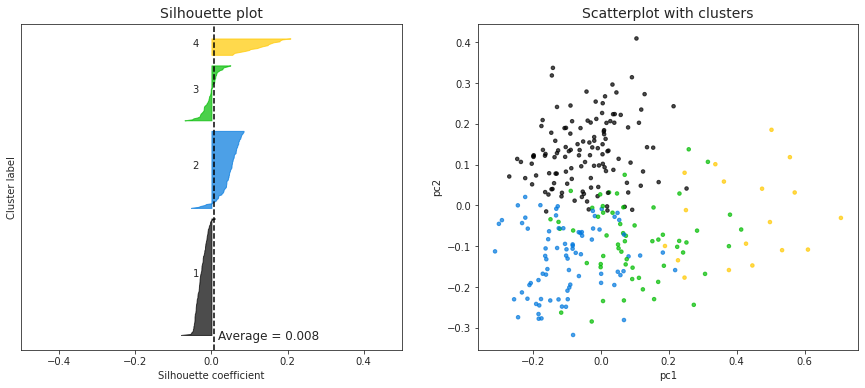

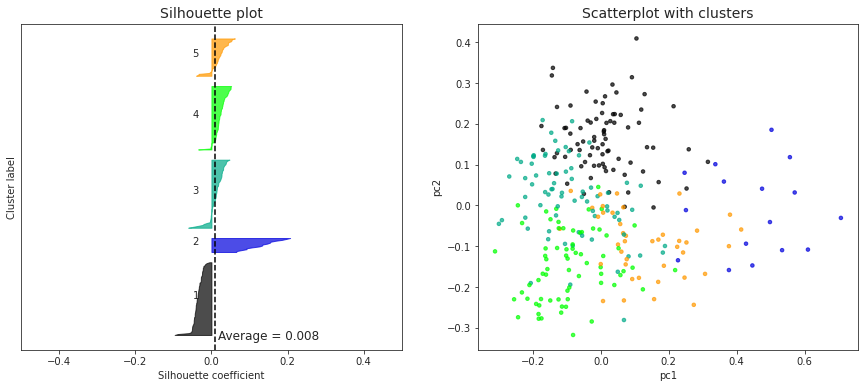

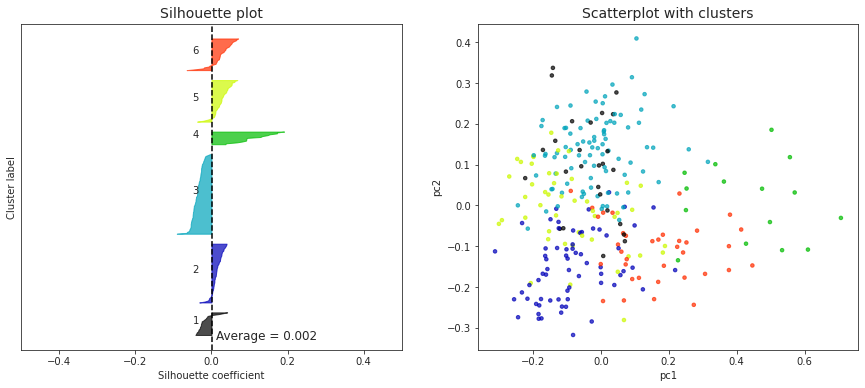

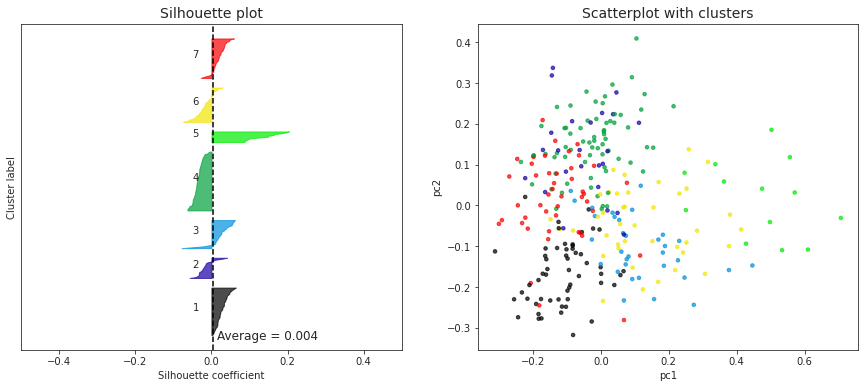

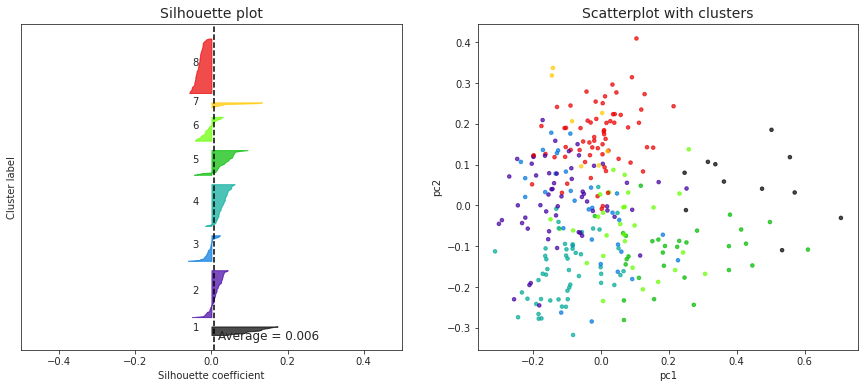

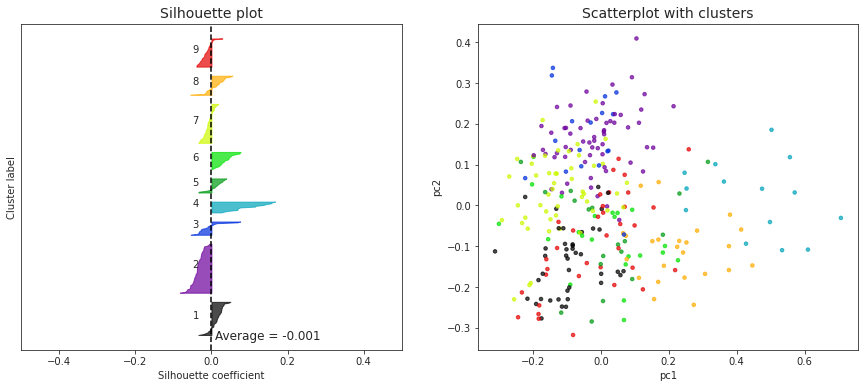

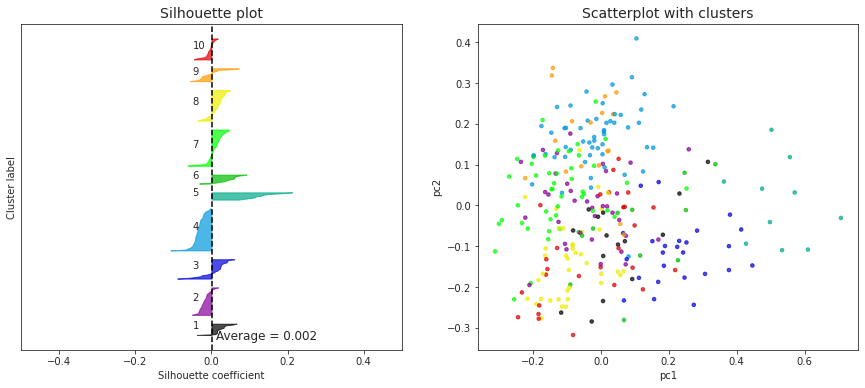

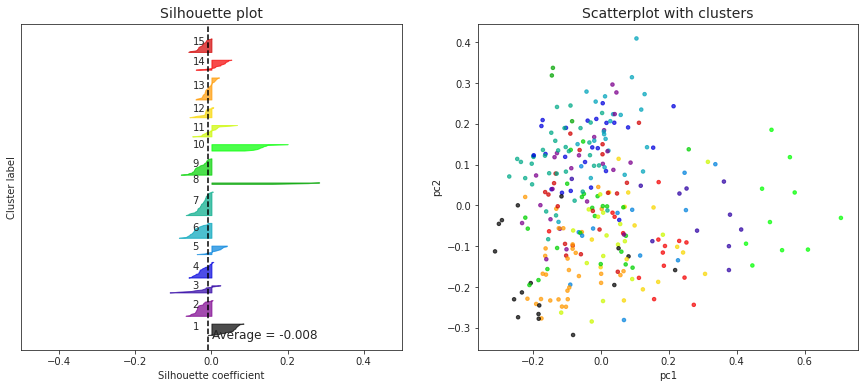

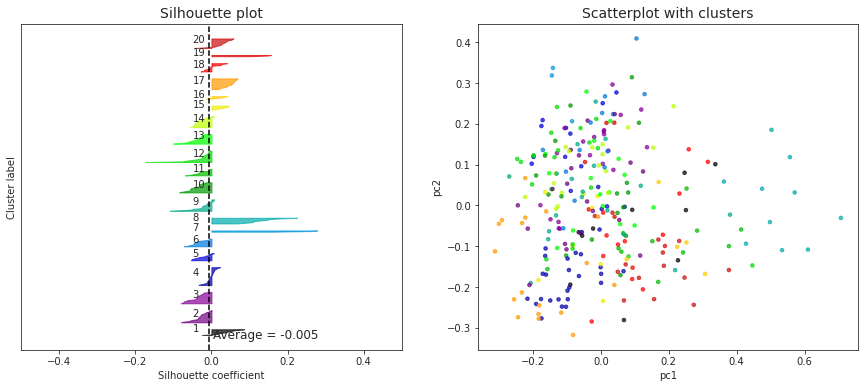

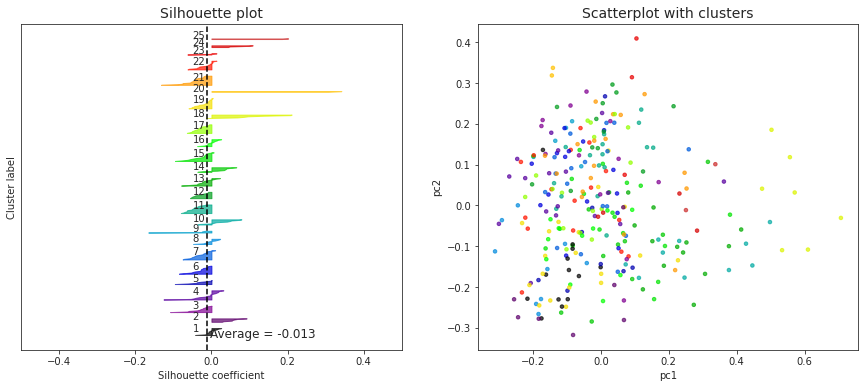

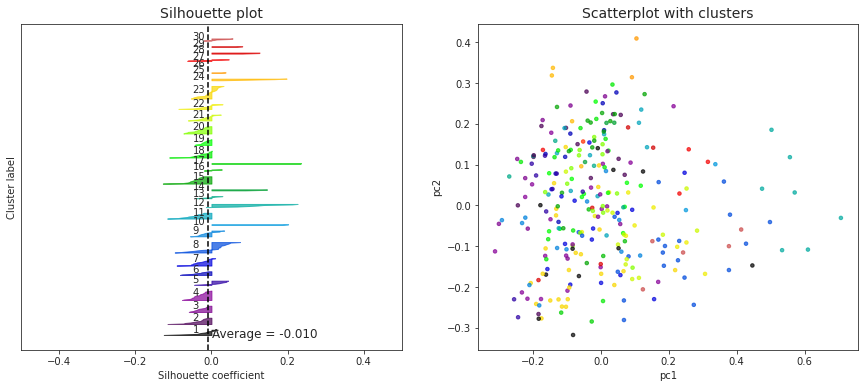

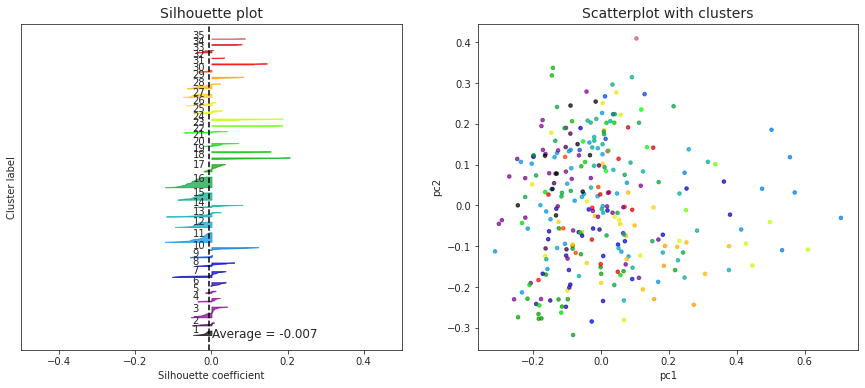

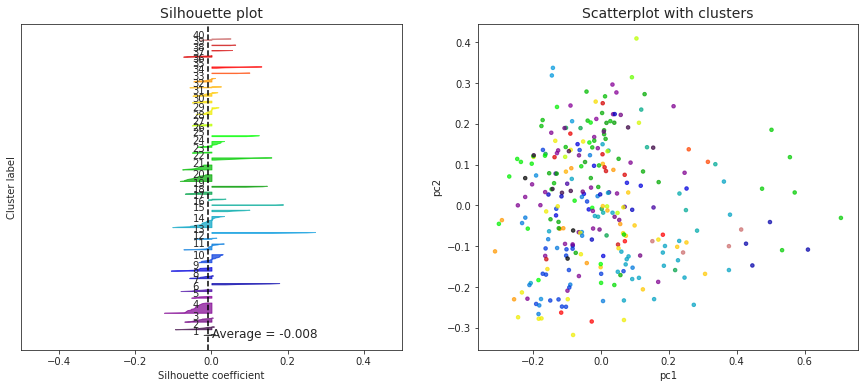

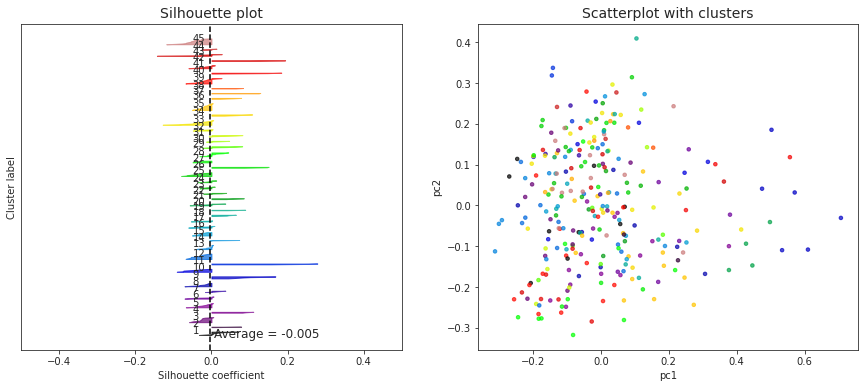

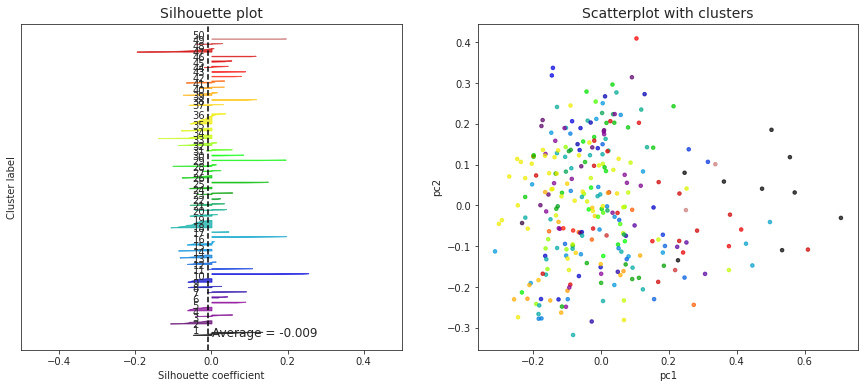

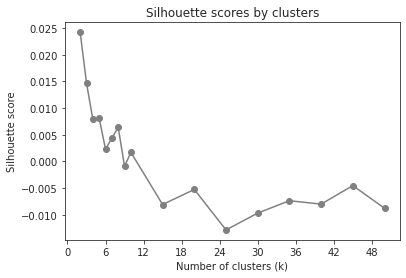

In [ ]:
# Visualising the results of spectral clustering

# Specify parameters
X = df_pc
X_with_pc = df_withpc
range_n_clusters = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]

# Specify the x and y variables to plot
scatter_x = 'pc1'
scatter_y = 'pc2'

# Create list to append avg silhouette scores
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
       
    # Instantiate the clusterer with n_clusters value and a random generator
    clusterer = SpectralClustering(n_clusters=n_clusters, assign_labels="kmeans", affinity = 'rbf', random_state = 42)
    cluster_labels = clusterer.fit_predict(X)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

    # Compute average silhouette_score and append to silhouette_avg_n_clusters list
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_avg_n_clusters.append(silhouette_avg)
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 6)
    
    # Plot silhouette and scatter plot
    plot_silhouette_scatter_nocenters(X_with_pc, range_n_clusters,scatter_x,scatter_y)
    
# Plot elbow plot
plot_elbow(range_n_clusters, silhouette_avg_n_clusters)

## 4.5 Gaussian Mixture Model
While similar to KMeans in certain aspects, GMM’s decision boundaries can be shaped as ellipsoids compared to KMeans’ circular boundaries, thus offering more flexibility and can be a better fit in certain cases. With little success in the earlier clustering methods, further analysis on the GMM’s probability scores may help to shed more light.

Two methods were used to determine the most appropriate number of clusters – (i) cross validation, to avoid overfitting, and (ii) evaluation of AIC and BIC scores.

### 4.5.1 Cross validation
Out of a range of 2 to 50 clusters, cross validation yielded **23 clusters as the most optimal**.

In [ ]:
# Supress all warnings with "Timestamp" in the message. This is because the dataframe has timestamp as column names.
import warnings
warnings.filterwarnings("ignore", message=".*Timestamp.*")


# Specify dataset
X = df_movement_clean

# Set up pipeline
steps = [('preprocessor', preprocessing.Normalizer()),
         ('pca', PCA(n_components=0.9)),
         ('model', GaussianMixture(random_state=42))
        ]
    
pipeline = Pipeline(steps)

# Specify hyperparameter space
parameters = {"model__covariance_type":["spherical", "tied", "diag", "full"],
              "model__n_components" : range(2,50),
              "model__n_init" : range(1,50)
             }


# Instantiate the RandomizedSearchCV object: cv
cv = model_selection.RandomizedSearchCV(pipeline,parameters, cv = 5)

# Fit to the training set
cv.fit(X)

print("Tuned Model Parameters: {}".format(cv.best_params_))

# Predict the labels of the set: y_pred
y_pred = cv.predict(X)

# Predict probabilities
probs = cv.predict_proba(X)


# Create df and csv file for probabilities
df_GMMprobs = pd.DataFrame(probs.round(3), index = X.index)
df_GMMprobs.to_csv('/content/drive/MyDrive/Specialist Diploma in Data Science (AI)/IT8302 Applied Machine Learning/Assignment/CA2/Stocks/GMM_probabilities.csv')

# Create df and csv file for cluster labels and normalised data
df_movement_normalized['gmm_labels']=y_pred
df_movement_normalized.to_csv('/content/drive/MyDrive/Specialist Diploma in Data Science (AI)/IT8302 Applied Machine Learning/Assignment/CA2/Stocks/GMM_clusters.csv')

Tuned Model Parameters: {'model__n_init': 17, 'model__n_components': 23, 'model__covariance_type': 'diag'}


In [ ]:
# Check for convergence in model with the best params

gmm = GaussianMixture(n_components=23,covariance_type="diag", random_state=42, n_init=17).fit(df_pc)
labels = gmm.predict(df_pc)

# did it converge?
print("Did it converge? {}".format(gmm.converged_))
print("gmm.n_iter_ {}".format(gmm.n_iter_))
#print("gmm.means {}".format(gmm.means_))

Did it converge? True
gmm.n_iter_ 13


### 4.5.2 AIC and BIC scores
AIC and BIC scores did not show a clear minimum point at which the GMM would perform best as a density estimator.

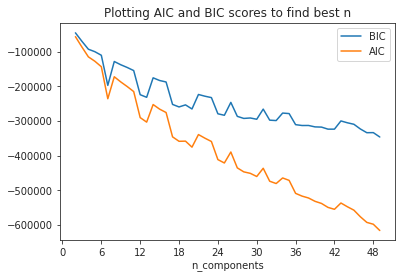

In [ ]:
n_components = range(2,50)
models = [GaussianMixture(n, covariance_type="diag", random_state=42, n_init=17).fit(X)
          for n in n_components]



fig, ax = plt.subplots()
ax.plot(n_components, [m.bic(X) for m in models], label='BIC')
ax.plot(n_components, [m.aic(X) for m in models], label='AIC')
ax.legend(loc='best')
ax.set_xlabel('n_components');
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Plotting AIC and BIC scores to find best n")
plt.show()

### 4.5.3 Post-hoc tests to see if the clusters are significantly different
Upon further examination of the clusters generated from the GMM model, post-hoc ANOVA analysis on each of the 759 periods did not reveal statistically significant differences between the clusters 69% of the time. P-values were greater than the 0.05 level of significance for 520 out of the 759 periods.

In [ ]:
# One way ANOVA to analyse if the clusters are significantly different

results = []

# Sample1, sample2... are clusters containing hourly data
# df_movement_normalized.shape[1] give the number of hours
for i in range(0,df_movement_normalized.shape[1]):
  result = stats.f_oneway(df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 0],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 1],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 2],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 3],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 4],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 5],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 6],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 7],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 8],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 9],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 10],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 11],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 12],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 13],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 14],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 15],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 16],
                         df_movement_normalized.iloc[:,i][df_movement_normalized['gmm_labels'] == 17]
                          )
  results.append(result)

# Create df and csv file for ANOVA results
anova_results = pd.DataFrame(results)

# Save as .csv
#anova_results.to_csv('/content/drive/MyDrive/Specialist Diploma in Data Science (AI)/IT8302 Applied Machine Learning/Assignment/CA2/Stocks/anova_results.csv')


# Count number of hours where p-value > 0.05 (5% level of significance)
nonsig = sum(anova_results.pvalue > 0.05)
nonsig_percent = nonsig/df_movement_normalized.shape[1]
print("{} hours have p-values more than 0.05 level of significance" .format(nonsig))
print("That is %.4f of the " % nonsig_percent + "{} hours".format(df_movement_normalized.shape[1])) 


520 hours have p-values more than 0.05 level of significance
That is 0.6851 of the 759 hours


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3349: RuntimeWarning:

divide by zero encountered in double_scalars



### 4.5.4 Visualising correlations within clusters
Furthermore, correlation tests within clusters mostly showed fairly weak correlations.

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:198: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:203: RuntimeWarning:

All-NaN slice encountered



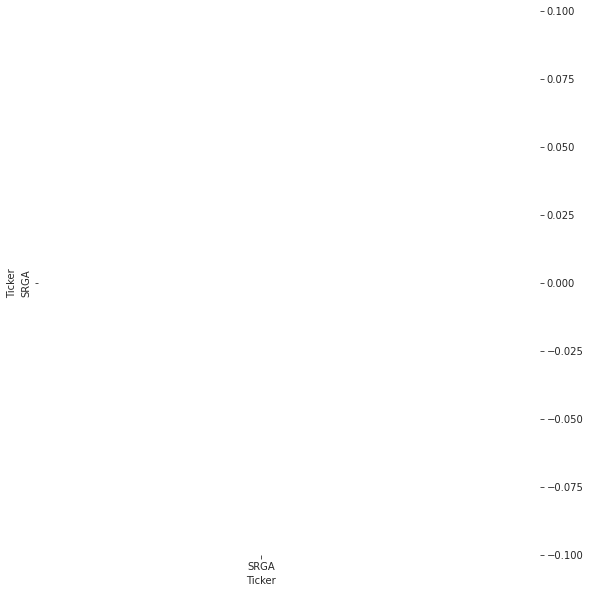

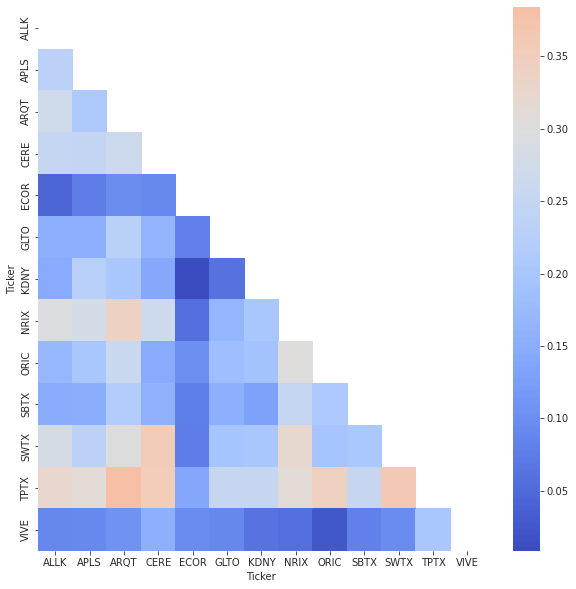

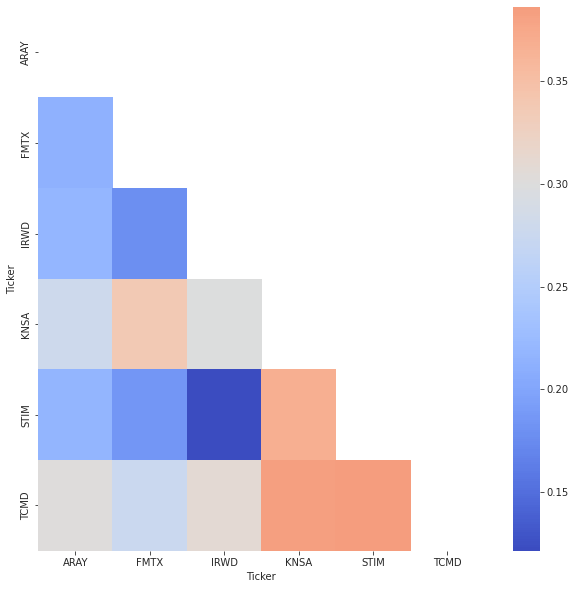

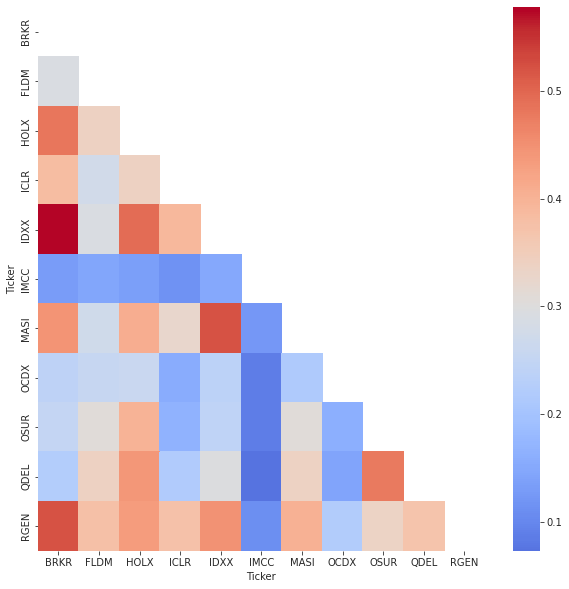

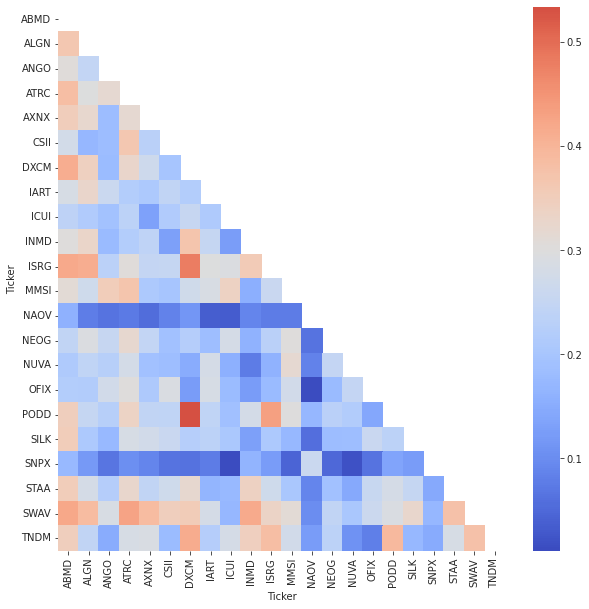

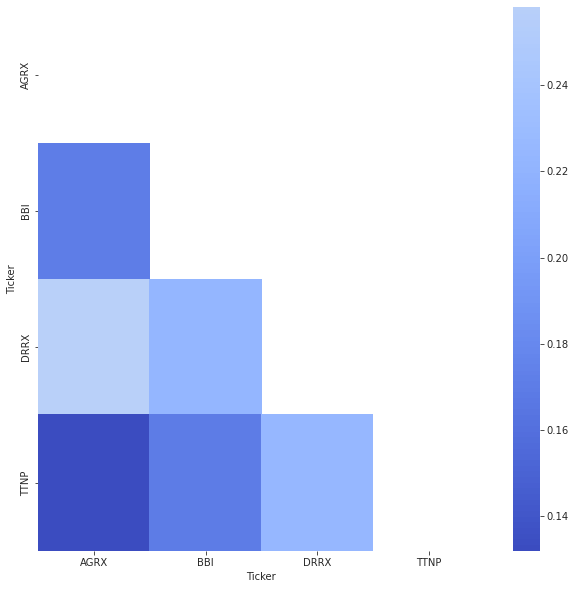

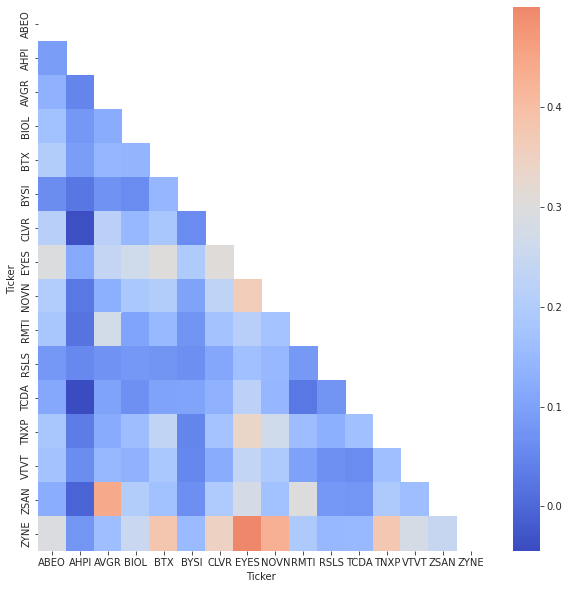

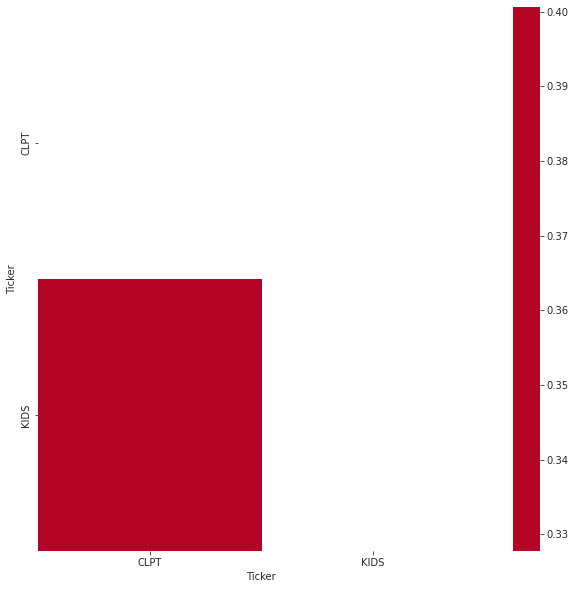

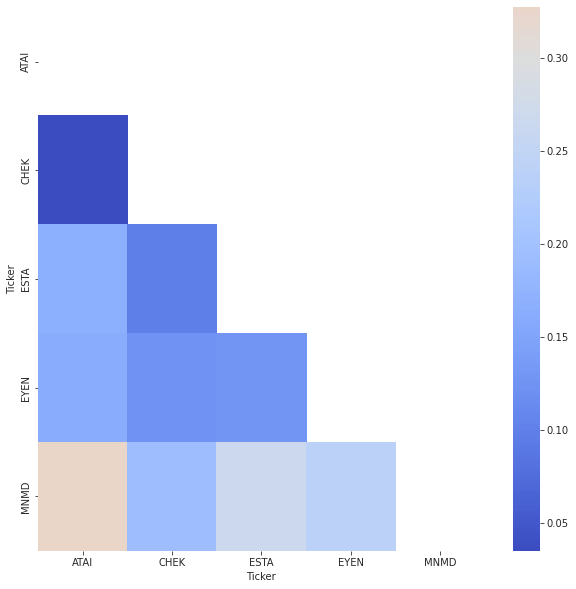

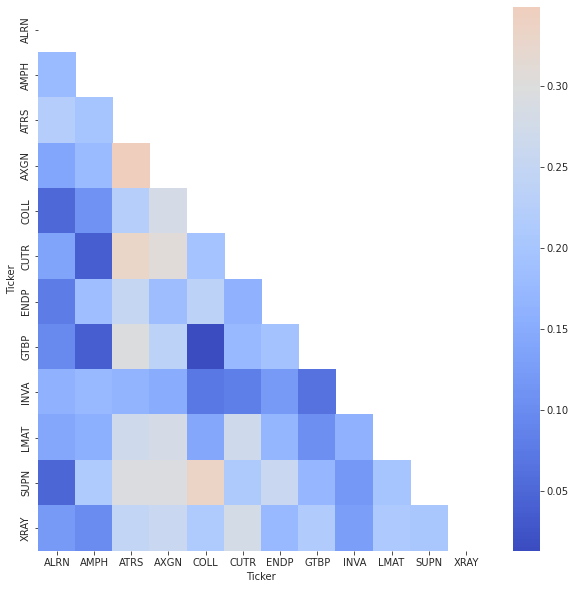

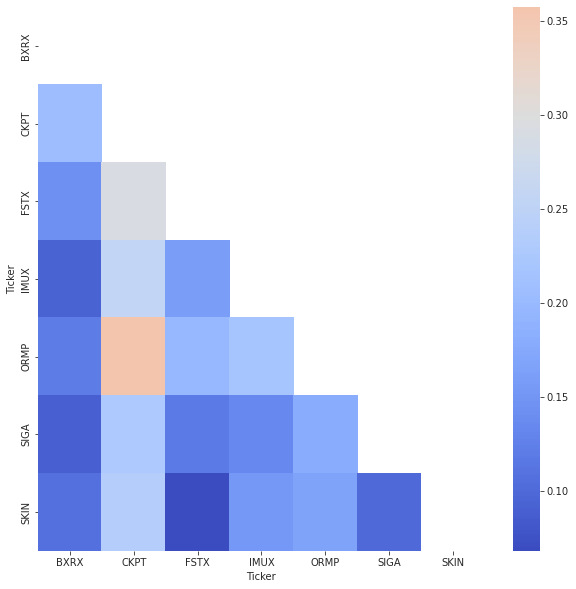

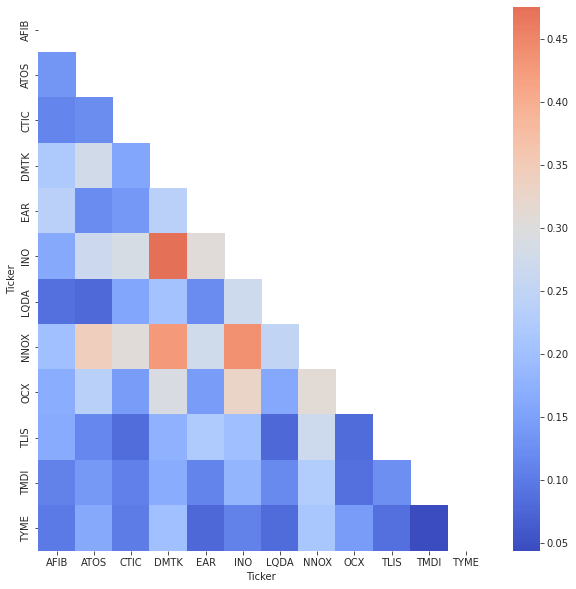

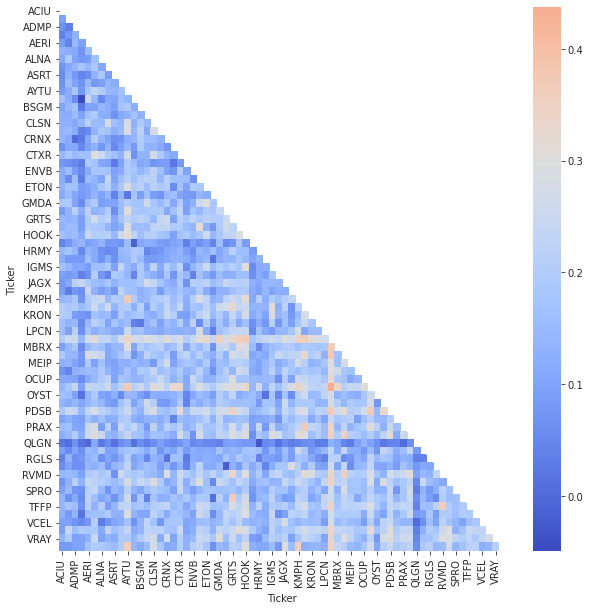

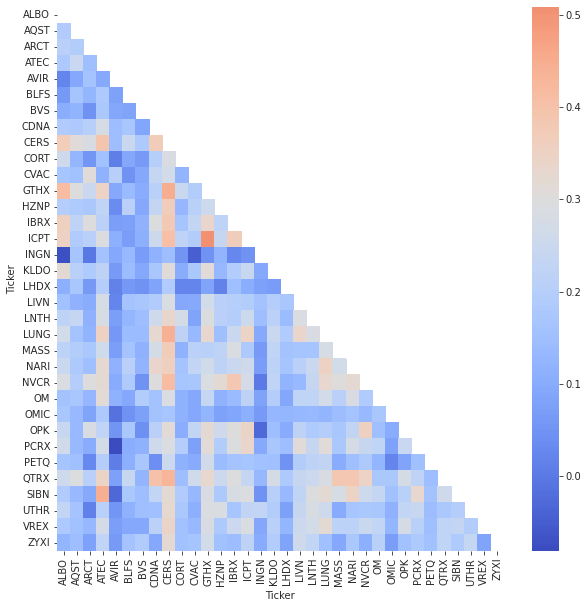

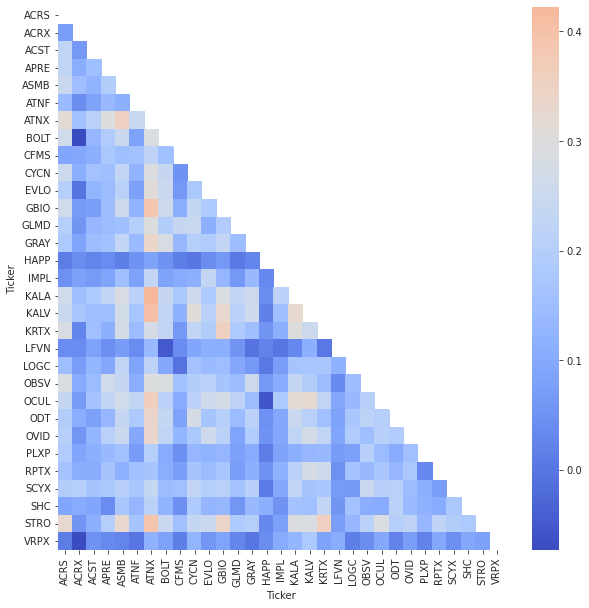

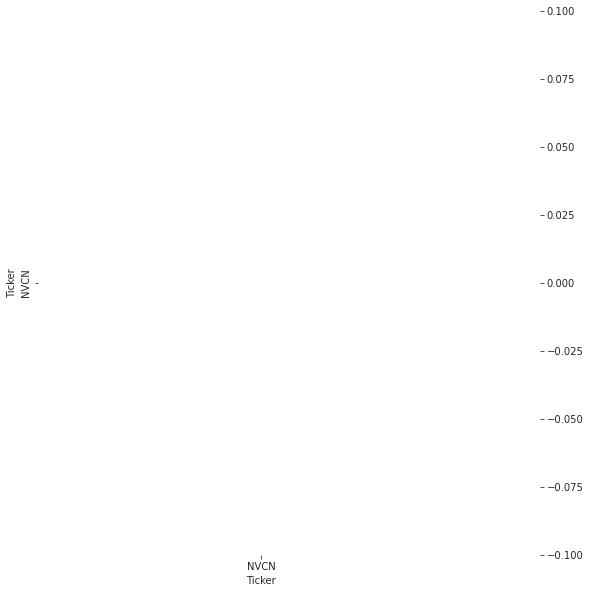

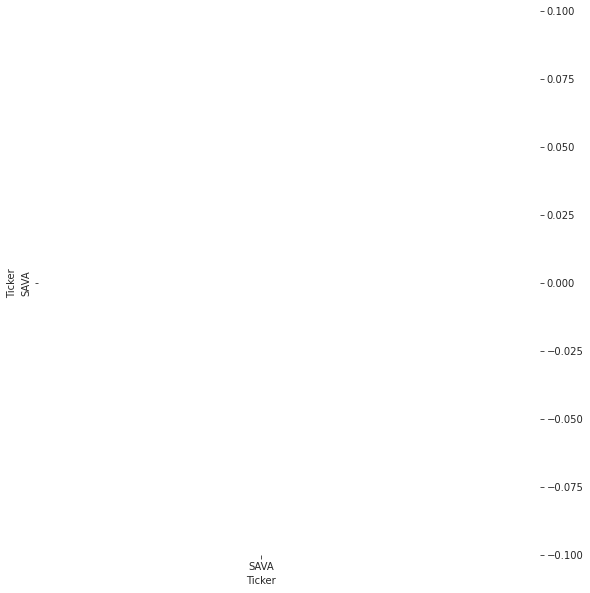

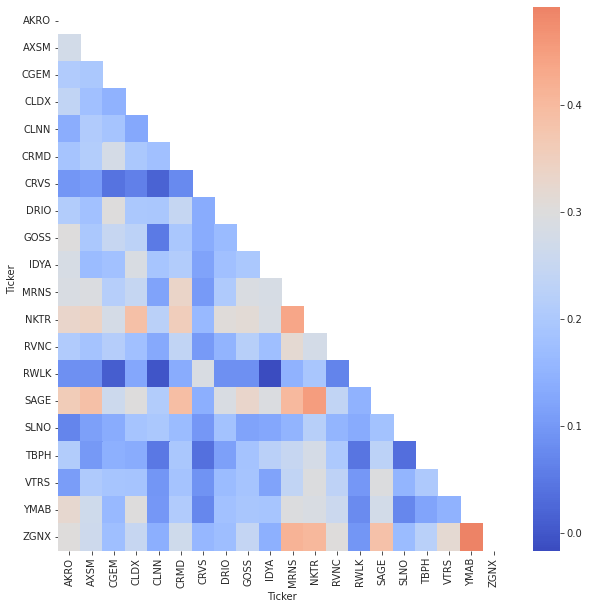

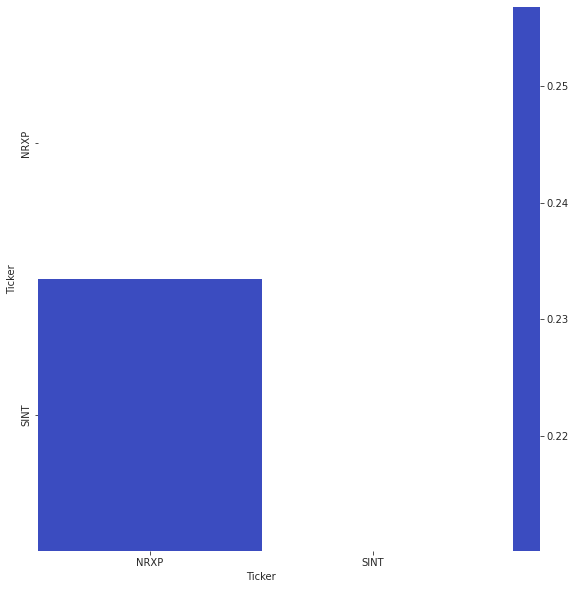

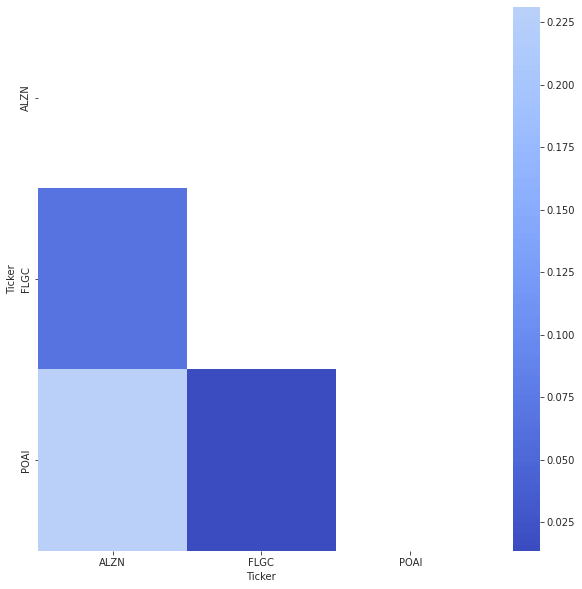

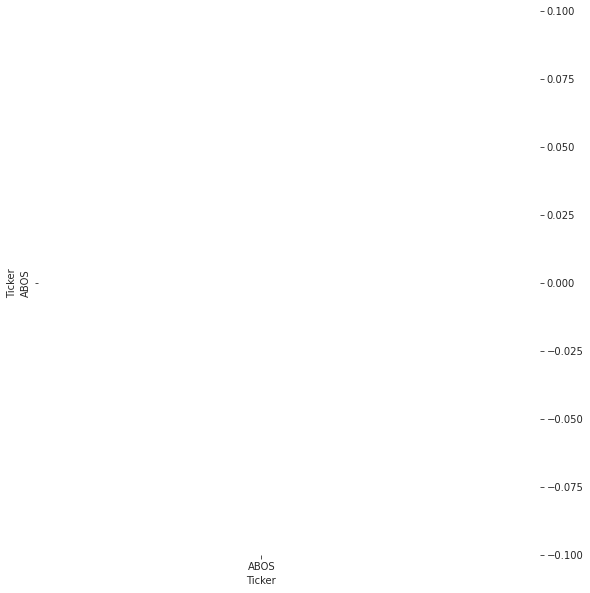

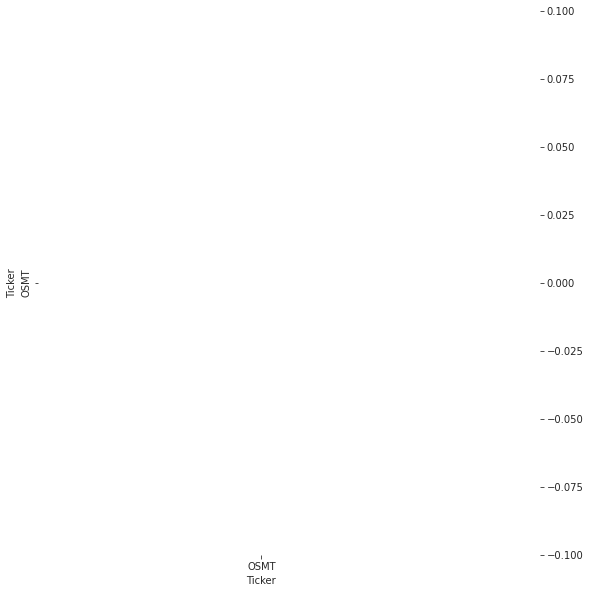

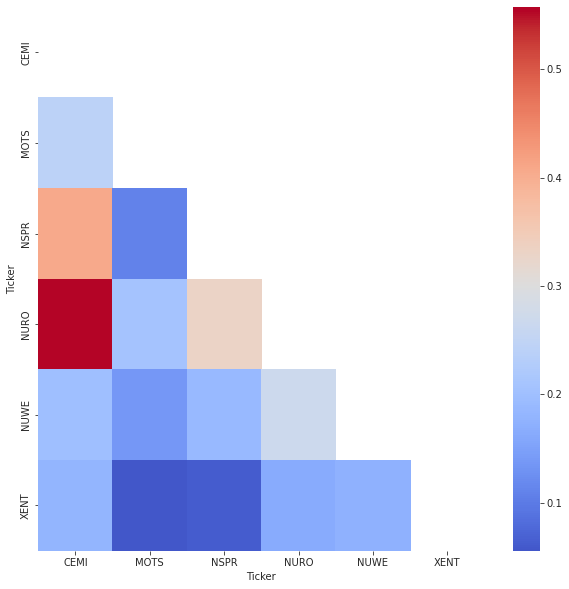

In [ ]:
# Create a loop to plot correlation heatmaps by GMM clusters

for i in range(0,23):
  # Keep a specific cluster
  filtered = df_movement_normalized[df_movement_normalized['gmm_labels']==i]
  df_corr = filtered.drop(columns=['gmm_labels']).T

  # Plot heatmap to visualise correlations
  plt.figure(figsize=(10,10))
  mask = np.triu(np.ones_like(df_corr.corr()))
  sns.heatmap(df_corr.corr(), annot=False, mask=mask, cmap = 'coolwarm', center=0.3)
  #plt.title('Correlation for stocks in cluster {}'.format(i+1))
  plt.show()

### 4.5.5 Analyse candlestick charts
Lastly, we will look at the candlestick charts to look for similar patterns across stocks in the same cluster. Visually, it is difficult to point out obvious similarities. This corroborates with earlier findings pointing to the lack of obvious clusters.

In [ ]:
# Specify cluster number
cluster_number = 4

# Get the tickers in the cluster
cluster_tickers = df_movement_normalized[df_movement_normalized['gmm_labels']==cluster_number].index

# Create a loop to plot candlestick charts for each ticker in the cluster
for ticker in cluster_tickers:
  data3 = yf.download(tickers = ticker,
                     start="2021-07-01",
                     end="2021-12-31",
                     #period = '6mo',
                    interval = '60m',
                    auto_adjust = True)
  candlestick = go.Candlestick(
    x=data3.index,
    open=data3['Open'],
    high=data3['High'],
    low=data3['Low'],
    close=data3['Close']
  )

  fig = go.Figure(data=[candlestick])
  fig.update_layout(title=ticker)
  fig.show()

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


# 5 Discussion
1. Based on stock movement data alone, KMeans, agglomerative, spectral and GMM clustering **did not yield strong conclusive evidence of distinct clusters of stocks** in the medical specialties and pharmaceutical industries listed on NASDAQ. Low silhouette scores, weak correlations and the lack of distinction among clusters point towards the lack of dissimilarity among groups, and the lack of similarity within groups.
2. A probable explanation would be that price movement, was not sufficient as a standalone metric for clustering. Past studies using company performance metrices such as price / earnings ratio [5] or other financial indicators such as the Treynor index [2] have been more successful in clustering similar stocks.
3. It is also possible that hourly-level data could have introduced too much noise when trying to identify medium-term clusters. Stocks may move in tandem for a few hours or days, and form a new cluster in the next week. Future research may consider using hourly data to identify weekly clusters, or using medium to long term data (this can also include company performance metrices) to identify clusters that last for months or more.

# 6 Conclusion

Clustering is a useful technique that can help to enhance investment strategies. This study explored various unsupervised clustering methods to identify “sympathy stocks” based on similar patterns in hourly price movements of stocks in the medical specialties and pharmaceutical industries. However, **results did not yield strong conclusive evidence of distinct clusters, suggesting that hourly price movement alone was an insufficient metric for identifying clusters that persist over a few months**. 

Despite this, there is potential for further research on clustering stocks based on price movements. Future research could explore the use of hourly data to identify weekly clusters, or using medium to long term data supplemented with other financial indicators to identify clusters that last for months or more.

# 7 References

1. S. R. Nanda, B. Mahanty, and M. K. Tiwari, “Clustering Indian stock market data 
for portfolio management,” Expert Systems with Applications, vol. 37, no. 12, pp. 8793–8798, Dec. 2010. . [Online serial]. Available: http://cie.ed.asu.edu/volume6/number12/. [Accessed Jan. 24, 2022].

2. S. N. Zainol Abidin, S. H. Jaaman, M. Ismail, and A. S. Abu Bakar, “Clustering stock performance considering investor preferences using a fuzzy inference system,” Symmetry, vol. 12, no. 7, p. 1148, 2020. [Online serial]. Available: ResearchGate, https://www.researchgate.net/publication/342856811. [Accessed Jan. 24, 2022].

3. O. Alqaryouti, T. Farouk, and N. Siyam, “Clustering stock markets for balanced portfolio construction,” Advances in Intelligent Systems and Computing, pp. 577–587, Aug. 2018. [Online serial]. Available: ResearchGate, https://www.researchgate.net/publication/327294932. [Accessed Jan. 24, 2022] .

4. H. He, J. Chen, H. Jin, and S.-H. Chen, “Trading strategies based on K-means clustering and regression models,” Computational Intelligence in Economics and Finance, pp. 123–134, 2007. [Abstract]. [Online serial]. Available: Springer, https://link.springer.com/chapter/10.1007/978-3-540-72821-4_7. [Accessed Jan. 24, 2022].

5. B. Tekin and F. Gümüş, “The classification of stocks with Basic Financial Indicators: An application of cluster analysis on the BIST 100 index,” SSRN Electronic Journal, vol. 7, no. 5, Apr. 2017. [Online serial]. Available: http://dx.doi.org/10.6007/IJARBSS/v7-i5/2881. [Accessed Jan. 24, 2022].

6. Y. Bai and J. Dang, “Clustering analysis of stock volume and price relationship based on gaussian mixture model,” Proceedings of the 2014 International Conference on Mechatronics, Electronic, Industrial and Control Engineering, 2014. [Online serial]. Available: https://doi.org/10.2991/meic-14.2014.350. [Accessed Jan. 24, 2022].

7. A. Mustika Rukmi, Soetrisno, and A. Wahid, “Role of clustering based on density to detect patterns of stock trading deviation,” Journal of Physics: Conference Series, vol. 1218, no. 1, p. 012053, 2019. [Online serial]. Available: https://iopscience.iop.org/article/10.1088/1742-6596/1218/1/012053/pdf. [Accessed Jan. 24, 2022].